<a href="https://colab.research.google.com/github/PaleoLipidRR/marine-AOA-GDGT-distribution/blob/main/PNAS_pythonCodeS2_BeyondTEX86_Analytics_Visualizations_RR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python Code S2**

## Supplementary Information for:
## Beyond TEX86: GDGT inform marine archaea ecology and evolution
Ronnakrit Rattanasriampaipong, Yi Ge Zhang, Ann Pearson, Brian Hedlund, and Shuang Zhang

Corresponding Author: Ronnakrit Rattanasriampaipong
E-mail: rrattan@tamu.edu
***

Notebook Description:

This is a jupyter notebook containing python scripts that we use to analyzed processed GDGT datasets (Dataset S2). The input file is an output from the Python Code S1 (see SI Appendix; Python Code S1, Dataset S1).

***


In [1]:
import warnings
warnings.filterwarnings("ignore") 
warnings.warn('ProplotWarning:')

# **1. Import python packages of interest**

### 1.1 Mounting your google drive with Google colab so that you can read files directly from the google drive

In [2]:
# # Mounting your google drive
# from google.colab import drive

# ROOT = "/content/drive"
# drive.mount(ROOT,force_remount=True)


### 1.2 Computation and Data Analytics

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns

import scipy as scipy
from scipy import stats
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score



### 1.2 Data plotting and visualizations

**Uncomment !apt-get if you run this notebook from Colab.**
shapely and cartopy are not good friends, especially on Google Colab

In [4]:
# ### %%capture is a command to suppress cell's outputs. So, please do not worry if you don't see anything coming out after running the cell. I just don't want to let the installations overwhelming your screen.
# %%capture
# !apt-get install libproj-dev proj-data proj-bin
# !apt-get install libgeos-dev
# %pip install cartopy
# !apt-get -qq install python-cartopy python3-cartopy
# %pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
# %pip install shapely --no-binary shapely
# %pip install proplot 
# %pip install pyrolite  ### This is to install libraries that are not available in Google Colab

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle

import proplot as plot
import cartopy.crs as ccrs

from pyrolite.util.time import Timescale
gts = Timescale()


###  1.3 Miscellaneous

In [6]:
import string
import os
import requests
import io
import netCDF4
from netCDF4 import Dataset

In [7]:
os.getcwd()

'C:\\Users\\ratta\\marine-AOA-GDGT-distribution'

###  1.4 Useful functions

In [8]:
def sigmaT_cal_Miller_and_Poisson_1981(temp_array,sal_array):
    '''
    This is a function for seawater density (sigma-t) calculation based on seawater temperature and salinity.
    The calculations follow Miller and Poisson (1981).
    
    Reference:
    Millero, F. J., & Poisson, A. (1981). International one-atmosphere equation of state of seawater. Deep Sea Research Part A. Oceanographic Research Papers, 28(6), 625-629.
    '''
    #Miller and Poisson (1981)
    #parameter for sigma calculation
    A = 8.24493e-1 - 4.0899e-3*temp_array + 7.6438e-5*(temp_array**2) - 8.2467e-7*(temp_array**3) + 5.3875e-9*(temp_array**4)
    B = -5.72466e-3 + 1.0227e-4*temp_array - 1.6546e-6*(temp_array**2)
    C = 4.8314e-4
    rho_0=999.842594 + 6.793952e-2*temp_array - 9.095290e-3*(temp_array**2) + 1.001685e-4*(temp_array**3) - 1.120083e-6*(temp_array**4) + 6.536336e-9*(temp_array**5)
    rho=rho_0 + (A*sal_array) + (B*(sal_array**1.5)) + (C*(sal_array**2))
    return rho-1000

def rollmean_calculation_step(sel_df,sel_attribute,younger_age,older_age,bin_step):
    '''
    sel_attribute is the column name e.g., 'paleoDepth_adjusted'
    
    Return the array with 5 columns:
    array_rollmean[:,0:4]
    0: plot_timestep
    1: mean
    2: median
    3: lower iqr (percentile 25th)
    4: upper iqr (percentile 75th)
    5: minimum of data range (percentile 0)
    6: maximum of data range (percentile 100)
    '''
    
    attributes = [sel_attribute]
    
    plot_timestep = np.arange(younger_age,older_age+bin_step,bin_step)
    nbins = len(plot_timestep)
    array_rollmean = np.empty((nbins,7))
    array_rollmean[:,0] = plot_timestep

    min_counts = 3


    sel_group = sel_df[sel_df.dataType_level0=="Ancient"]

    for i in range(len(array_rollmean[:,0])):
        if sel_group[sel_attribute].where((sel_group.sampleAge>=plot_timestep[i])&
                                          (sel_group.sampleAge<plot_timestep[i]+bin_step)).count() <=min_counts:
            array_rollmean[i,1] = np.nan
            array_rollmean[i,2] = np.nan
            array_rollmean[i,3] = np.nan
            array_rollmean[i,4] = np.nan
            array_rollmean[i,5] = np.nan
            array_rollmean[i,6] = np.nan


        else:
            bin_data = sel_group[sel_attribute].where((sel_group.sampleAge>=plot_timestep[i])&
                                                      (sel_group.sampleAge<plot_timestep[i]+bin_step))
            array_rollmean[i,1] = bin_data[~np.isnan(bin_data)].mean()
            
            a = scipy.stats.mstats.mquantiles(bin_data[~np.isnan(bin_data)], prob=[0,0.25, 0.5, 0.75,1], alphap=0.4, betap=0.4,axis=None, limit=())
            array_rollmean[i,2] = a[2]
            array_rollmean[i,3] = a[1]
            array_rollmean[i,4] = a[3]
            
            array_rollmean[i,5] = a[0]
            array_rollmean[i,6] = a[4]


            
    return array_rollmean


#### codes to generate woa urls modified from https://pyoceans.github.io/python-oceans/_modules/oceans/datasets.html
def _woa_variable(variable):
    _VAR = {
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'dissolved_oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
    }
    v = _VAR.get(variable)
    if not v:
        raise ValueError(
            f'Unrecognizable variable. Expected one of {list(_VAR.keys())}, got "{variable}".'
        )
    return v

def _woa_url(variable, time_period, resolution):
    base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC'

    v = _woa_variable(variable)

    if variable not in ['salinity', 'temperature']:
        pref = 'woa09'
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        return (
            f'{base}/'
            f'{pref}/'
            f'{variable}_annual_1deg.nc'
        )
    else:
        dddd = 'decav'
        pref = 'woa18'

    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }

    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )

    url = (
        f'{base}'
        '/ncei/woa/'
        f'{variable}/decav/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )
    return url

   #  variables:
   #      'temperature': 't',
   #      'salinity': 's',
   #      'silicate': 'i',
   #      'phosphate': 'p',
   #      'nitrate': 'n',
   #      'oxygen_saturation': 'O',
   #      'dissolved_oxygen': 'o',
   #      'apparent_oxygen_utilization': 'A',
   # time_periods:
   #      'annual': '00',
   #      'january': '01',
   #      'february': '02',
   #      'march': '03',
   #      'april': '04',
   #      'may': '05',
   #      'june': '06',
   #      'july': '07',
   #      'august': '08',
   #      'september': '09',
   #      'october': '10',
   #      'november': '11',
   #      'december': '12',
   #      'winter': '13',
   #      'spring': '14',
   #      'summer': '15',
   #      'autumn': '16',
   # resolutions:
   #  '5': ('5deg', '5d'),
   #  '1': ('1.00', '01'),
   #  '04': ('0.25', '04'),
        

    # an=Objectively analyzed climatologies are the objectively interpolated mean fields for oceanographic variables at standard depth levels for the World Ocean.
    # mn=The statistical mean is the average of all unflagged interpolated values at each standard depth level for each variable in each 1° square which contains at least one

# **2. Load and clean datasets**

## **2.1 Read xlsx/csv files as pandas dataframe**

In [9]:
pd.set_option('display.max_rows',4,'display.max_columns',10)
# filepath = "/content/drive/MyDrive/Colab Notebooks/Excel/MarineAOA_project/"  ### Replace with your the location of your file --- for mounted Google Drive
filepath = "C:/Users/ratta/working-repo/spreadsheets/"  ### for local Git repository
filename = "PNAS_datasetS2_BeyondTEX86_RR.xlsx"
df = pd.read_excel(filepath+filename,sheet_name='Sheet1')
df = df.iloc[:,1:]  ##This line is to remove the Unnamed: 0 column (the additional column after completing the pythonCodeS1 pre-processing)
df

,sampleName,drilling_program,Site,Site_edited,Latitude,...,match_depth,match_lat,match_lon,oceanLayer_class,paleoWaterDepth
0,Bijl2021_014_1172D_2R-5W_140.5_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
1,Bijl2021_015_1172D_2R-6W_44545_,IODP-offshore,1172,"Tasman Sea, Southern Ocean",-43.9598,...,NaN,NaN,NaN,NaN,2720.0
...,...,...,...,...,...,...,...,...,...,...,...
5083,Zhu2016_327_IPL_ETNP_ST8_50,N/A-SPM,ETNP,ETNP,13,...,50.0,12.875,-105.125,Surface ocean,50.0
5084,Zhu2016_328_IPL_ETNP_ST8_125,N/A-SPM,ETNP,ETNP,13,...,125.0,12.875,-105.125,Surface ocean,125.0


## **2.2. Import WOA18 data and generate seawater density (sigma-T)**

### 2.2.1 Annual average dataset from the multi-decadal climatologies (0.25degx0.25deg; 1955-2017)

In [10]:
#### Uncomment this cell if you have netcdf files in your local directory
# filepath = "C:/Users/ratta/OneDrive - Texas A&M University/Marine AOA Evolution_shared/Desktop/netcdf/"  ### change filepath to your local directory
# ts_decav_filename = 'woa18_decav_t00_04.nc'
# ts = xr.open_mfdataset(filepath+ts_decav_filename,decode_times=False,chunks={'time':1,'depth':1,'lon':100})

# ss_decav_afilname = 'woa18_decav_s00_04.nc'
# ss = xr.open_mfdataset(filepath+ss_decav_filname,decode_times=False,chunks={'time':1,'depth':1,'lon':100})

In [11]:
url = _woa_url('temperature','00','04')
ts = xr.open_dataset(url,decode_times=False,chunks={'time':1,'depth':1})
ts

<xarray.Dataset>
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    t_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    t_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    t_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

In [12]:
url = _woa_url('salinity','00','04')
ss = xr.open_dataset(url,decode_times=False,chunks={'time':1,'depth':1})
ss

<xarray.Dataset>
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    s_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_salin...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, D. Seidov, T....
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-30 
    date_modified:                   2019-07-30

### 2.2.2 Monthly average dataset from the multi-decadal climatologies (0.25degx0.25deg; 1955-2017)#### Uncomment this cell if you have netcdf files in your local directory

In [13]:
#### Uncomment this cell if you have netcdf files in your local directory
# filepath = "/content/drive/MyDrive/Colab Notebooks/netcdf/WOA18_monthly/" ### change filepath to your local directory
# ts_mon_filname ="woa18_decav_t*.nc"
# ts_mon = xr.open_mfdataset(filepath+ts_mon_filname,concat_dim='time',decode_times=False,combine = 'nested',chunks={'time':1,'depth':1,'lon':100})

# ss_mon_filname ="woa18_decav_s*.nc"
# ss_mon = xr.open_mfdataset(filepath+ss_mon_filname,concat_dim='time',decode_times=False,combine = 'nested', chunks={'time':1,'depth':1,'lon':100})

# mon_rng = np.linspace(1,12,12)
# ts_mon = ts_mon.update({"time":("time",mon_rng)})
# ss_mon = ss_mon.update({"time":("time",mon_rng)})

In [14]:
url_list = []
for i in range(12):
    url = _woa_url('temperature',str(i+1).zfill(2),'04') ### extracting files from 01 to 12 (January to December)
    url_list.append(url)
url_list
ts_mon = xr.open_mfdataset(url_list,concat_dim='time',decode_times=False,combine = 'nested',chunks={'time':1,'depth':1})

In [15]:
url_list = []
for i in range(12):
    url = _woa_url('salinity',str(i+1).zfill(2),'04') ### extracting files from 01 to 12 (January to December)
    url_list.append(url)
url_list
ss_mon = xr.open_mfdataset(url_list,concat_dim='time',decode_times=False,combine = 'nested',chunks={'time':1,'depth':1})
ss_mon

<xarray.Dataset>
Dimensions:             (time: 12, lat: 720, nbounds: 2, lon: 1440, depth: 57)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float64 372.5 373.5 374.5 ... 381.5 382.5 383.5
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds            (time, lat, nbounds) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds            (time, lon, nbounds) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    depth_bnds          (time, depth, nbounds) float32 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    s_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ...                  ...
    s_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_ma                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    s_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_salin...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, D. Seidov, T....
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-30 
    date_modified:                   2019-07-30

## 2.3 Calculate seawater density (sigma-T) from imported temperture and salinity following Millero and Poission (1981)

Reference: <br>
Millero, F. J., & Poisson, A. (1981). International one-atmosphere equation of state of seawater. Deep Sea Research Part A. Oceanographic Research Papers, 28(6), 625-629.

### *2.3.1 Annual average of Sigma-T climatologies**

In [16]:
#Load t_an and s_an data
t_an_all = ts.t_an.isel(time=0)
s_an_all = ss.s_an.isel(time=0)

sel_t = t_an_all
sel_s = s_an_all

sigma_all=sigmaT_cal_Miller_and_Poisson_1981(sel_t,sel_s)
sigma_all

<xarray.DataArray (depth: 102, lat: 720, lon: 1440)>
dask.array<sub, shape=(102, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    time     float32 4.326e+03

### **2.3.2 Monthly average of Sigma-T climatologies**

In [17]:
#Load t_an and s_an data
t_an_all_mon = ts_mon.t_an
s_an_all_mon = ss_mon.s_an

sel_t = t_an_all_mon
sel_s = s_an_all_mon

sigma_all_mon=sigmaT_cal_Miller_and_Poisson_1981(sel_t,sel_s)
sigma_all_mon = sigma_all_mon.chunk(chunks={'depth':57})
sigma_all_mon

<xarray.DataArray (time: 12, depth: 57, lat: 720, lon: 1440)>
dask.array<rechunk-merge, shape=(12, 57, 720, 1440), dtype=float32, chunksize=(1, 57, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
  * time     (time) float64 372.5 373.5 374.5 375.5 ... 380.5 381.5 382.5 383.5

### **2.3.3 Standard deviation volution of monthly average of Sigma-T climatologies**

In [18]:
sigma_mon_std = sigma_all_mon.std(dim='time')
sigma_mon_std

<xarray.DataArray (depth: 57, lat: 720, lon: 1440)>
dask.array<_sqrt, shape=(57, 720, 1440), dtype=float32, chunksize=(57, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03

# **3. Data preparation**

## **3.1 Some labeling adjustments that will ease my data visualizations**

In [19]:
new_dataType = []
for i in range(df.shape[0]):
    if df.dataType_level1.iloc[i] == 'Core top':
        if df.oceanLayer_class.iloc[i] == 'Surface ocean':
            new_dataType.append('Shallow core top')
        elif df.oceanLayer_class.iloc[i] == 'Deep ocean':
            new_dataType.append('Deep core top')
        else:
            new_dataType.append(df.dataType_level1.iloc[i])
    elif df.dataType_level1.iloc[i] == 'Water-column SPM':
        if df.oceanLayer_class.iloc[i] == 'Surface ocean':
            new_dataType.append('Shallow SPM')
        elif df.oceanLayer_class.iloc[i] == 'Deep ocean':
            new_dataType.append('Deep SPM')
        else:
            new_dataType.append(df.dataType_level1.iloc[i])
    else:
        new_dataType.append(df.dataType_level1.iloc[i])

df['dataType_level3'] = new_dataType
df.dataType_level3.unique()

array(['Early Cenozoic', 'Late Cenozoic', 'Mesozoic', 'Culture - AOA',
       'Culture - Hot spring', 'Culture - ThAOA', 'Deep core top',
       'Shallow core top', 'Hot spring', 'Shallow SPM', 'Deep SPM'],
      dtype=object)

## **3.2 Paleo-water depth adjustment**

For some paleo water depths that are above sea level (SL), we will assume those paleo depths to be at SL (0m)

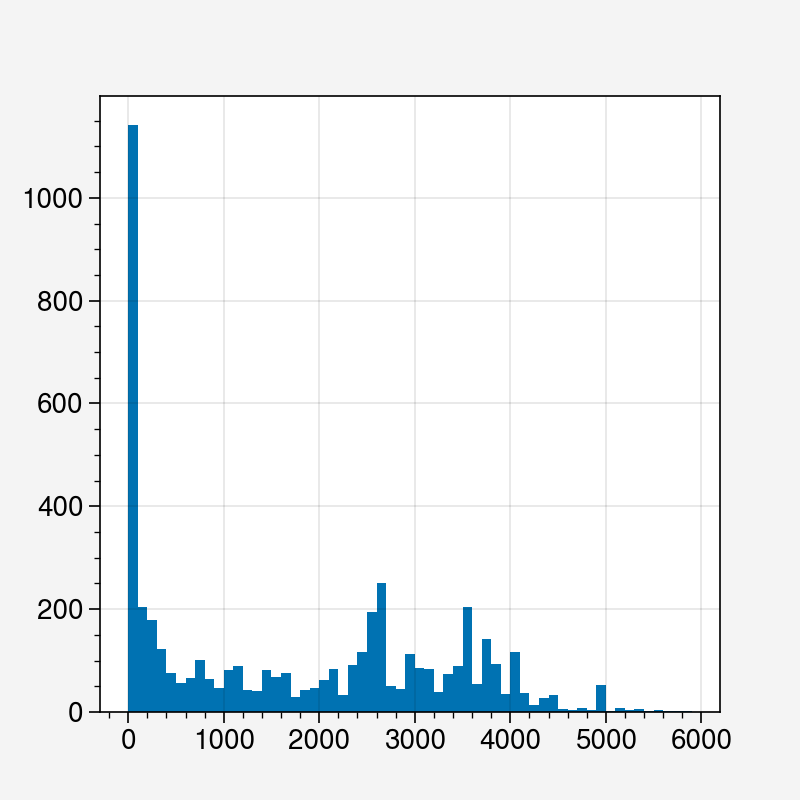

In [20]:
for i in range(len(df.paleoWaterDepth)):
    if df.paleoWaterDepth.iloc[i] < 0:
        df.paleoWaterDepth.iloc[i] = 0
    else:
        continue
        
df.paleoWaterDepth.hist(bins=np.arange(0,6000,100))
plt.show()

## **3.3 Splitting IPL, non-IPL, and hot spring datasets**

In [21]:
df_IPL = df[df.lipidClass=='IPL-GDGTs']
df_nonIPL = df[df.lipidClass!='IPL-GDGTs'][((df.dataType_level1!='Culture - Hot spring')&
                                            (df.dataType_level1!='Hot spring')&
                                            (df.dataType_level1!='Culture - ThAOA')
                                           )]

## We separate hot spring datasets as the GDGT QC indices may not applicable with the thermophilic archaea                                       
df_nonIPL_hs = df[df.lipidClass!='IPL-GDGTs'][((df.dataType_level1=='Culture - Hot spring')|
                                            (df.dataType_level1=='Hot spring')|
                                            (df.dataType_level1=='Culture - ThAOA')
                                           )]

# **4. Data visualizations**

## **4.1 Dictionaries for data visualizations**

In [22]:
colors_mapping = {'Culture - Hot spring':'red9',
                  'Culture - ThAOA':'red5',
                  'Culture - AOA':'teal7',
                  'Hot spring':'gold',  #yellow Hot Springs #EDC948
                  'Shallow SPM':'lime3', #lightgreen Water-column SPM (0-100m)
                  'Deep SPM':'lime7', #green Water-column SPM
                  'Shallow core top':'blue3',  #light blue Core Top (0-100m)
                  'Deep core top':'blue7',  #blue Core Top
                  'Late Cenozoic':'yellow3',  #light organge Late Cenozoic
                  'Early Cenozoic':'yellow7',  #orange Early Cenozoic
                  'Mesozoic':'#B07AA1',  #purple Mesozoic
                  'C0 cluster':'#1F77B4',
                  'C1 cluster':'#FF7F0E',
                 }

plots_mapping = {'Culture - Hot spring':0,
                 'Culture - ThAOA':1,
                 'Culture - AOA':3,
                 'Hot spring':2,
                 'Shallow SPM':4,
                 'Deep SPM':6,
                 'Shallow core top':5,
                 'Deep core top':7,
                 'Late Cenozoic':8,
                 'Early Cenozoic':9,
                 'Mesozoic':10,  
                 }

plots_mapping2 = {'Hot spring':0,
                 'Shallow SPM':1,
                 'Deep SPM':3,
                 'Shallow core top':2,
                 'Deep core top':4,
                 'Late Cenozoic':5,
                 'Early Cenozoic':6,
                 'Mesozoic':7,  
                 }

names_mapping={'Culture - Hot spring':r'$\it{Crenarchaeota}$ cultures',
               'Culture - ThAOA':'ThAOA cultures',
               'Culture - AOA':'Shallow AOA cultures',
               'Hot spring':'Hot spring mats',
               'Shallow SPM':'Shallow SPM',
               'Deep SPM':'Deep SPM',
               'Shallow core top':'Shallow core tops',
               'Deep core top':'Deep core tops',
               'Late Cenozoic':'Late Cenozoic',
               'Early Cenozoic':'Early Cenozoic',
               'Mesozoic':'Mesozoic',  
             }
colors_GMM_mapping = {0:'#1F77B4',
                      '0':'#1F77B4',
                      1:'#FF7F0E',
                      '1':'#FF7F0E',
                      2:'#BAB0AC',
                      '2':'#BAB0AC'
                      }

month_mapping = { 0 : 'Jan',
                 1 : "Feb",
                 2 : "Mar",
                 3 : "Apr",
                 4 : "May",
                 5 : "Jun",
                 6 : "Jul",
                 7 : "Aug",
                 8 : "Sep",
                 9 : "Oct",
                 10 : "Nov",
                 11 : "Dec"
}

## **4.2 Figures in main text**

### **4.2.1 Figure 1 in main text**

In [23]:
def fig1_mainText_PNAS_MarineAOA():
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none',
                     'text.labelsize':'10',
                     'facecolor':'#FFFFFF',
                     'fontname': 'TeX Gyre Heros'
                    }
    plot.rc.update(new_rc_params)
    plot_data = pd.concat([df_nonIPL[df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs]).dropna(how='any',subset=['TEX86','gdgt23ratio'])
    
    fig, axs = plot.subplots(ncols=1,nrows=1)
    axs.format(
        xlabel='xlabel', ylabel='Data Type',
        xtickminor=True, xgridminor=True, xgrid=True,
    )
    
    orders = ["Culture - Hot spring","Culture - ThAOA","Hot spring","Culture - AOA","Shallow SPM", "Shallow core top",
              "Deep SPM","Deep core top","Late Cenozoic","Early Cenozoic","Mesozoic"]
    colors = ['red9',
              'red5',
              'gold',  #yellow Hot Springs #EDC948
              'teal7',
              'lime3', #lightgreen Water-column SPM (0-100m)
              'blue3',  #light blue Core Top (0-100m)
              'lime7', #green Water-column SPM
              'blue7',  #blue Core Top
              'yellow3',  #light organge Late Cenozoic
              'yellow7',  #orange Early Cenozoic
              '#B07AA1',  #purple Mesozoic
             ]
    
    yposlist = plot_data.groupby(plot_data.dataType_level3)[['dataType_level3','gdgt23ratio']].median()
    yposlist = pd.DataFrame(yposlist, index=orders)
    
    countlist = plot_data.groupby(plot_data.dataType_level3)[['dataType_level3','gdgt23ratio']].count()
    countlist = pd.DataFrame(countlist, index=orders)
    
    dataType_abc = list(string.ascii_uppercase)
    
    sns.set_palette(sns.color_palette(colors))
    
    ax = axs[0]
    sns.violinplot(y="dataType_level3", x="gdgt23ratio", data=plot_data, palette=colors,
                   order=orders,
                   lc='gray5',
                   linewidth=1,
                   width=0.7,
                   showmeans=True,
                   trim=True,
                   scale='width',
                   ax=ax)
    
    for i in range(len(yposlist)):
        group_median='%.2f'%yposlist['gdgt23ratio'][i]
        ax.text(yposlist['gdgt23ratio'][i]+6,i-0.08,
                f"{group_median} "+f"(n = {countlist.gdgt23ratio[i]})")
        ax.text(28.5,i-0.08,dataType_abc[i],fontweight='bold')
        
    ax.set_yticklabels([r'$\it{Thermoproteia}$ cultures',
                        'ThAOA cultures',
                        'Hot spring mats',
                        'Shallow AOA cultures',
                        'Shallow SPM',
                        'Shallow core tops',
                        'Deep SPM',
                        'Deep core tops',
                        'Late Cenozoic',
                        'Early Cenozoic',
                        'Mesozoic'
                       ])
    ax.format(
        abc=False,
        xlabel=('GDGT-2/-3'),
        xlim = (0,30),
        xlocator=5, xminorlocator=1,
        xtickloc='bottom',
        ylabel='',
        ytickminor=False
    )
    # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
    filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\main-text\\"
    figname = 'fig1_PNAS_violin_plots'
    fig.savefig(filepath+figname+'.pdf',dpi=330,bbox_inches='tight')
    plt.show()

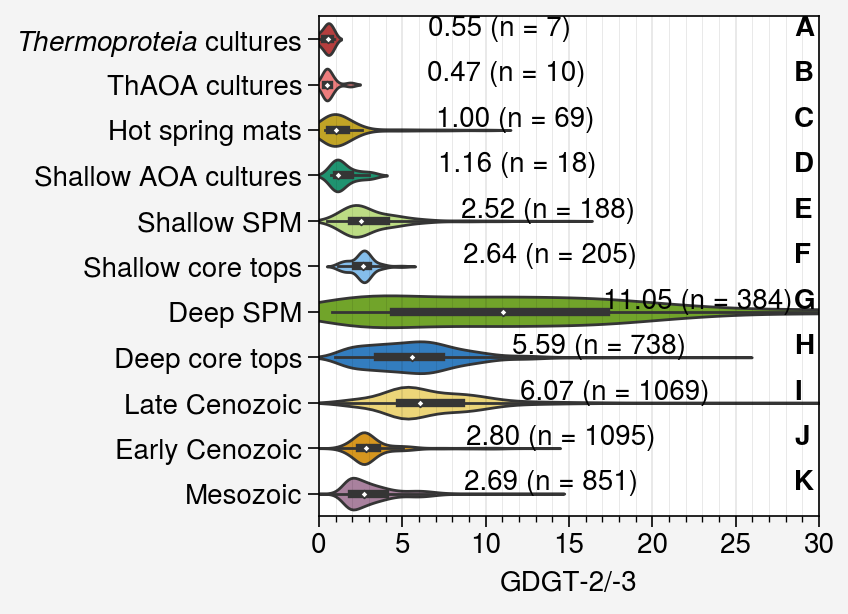

In [24]:
fig1_mainText_PNAS_MarineAOA()

### Figure 1. Ranges and distributions of GDGT-2/-3 ratios from different archives (top panel)
Figure caption
>Fig. 1 (Top) Ranges and distributions of GDGT-2/-3 ratios from different archives and (Bottom) structures of common GDGTs found in marine settings. (A) Cultures of thermophilic Crenarchaeota. (B) Cultures of thermophilic AOA strains. (C) Environmental samples from terrestrial hot spring algal mats from sites with pH≥ 6.5. (D) Cultures of known shallow AOA strains. Globally distributed suspended particulate matter (SPM) from (E) above (shallow SPM) and (F) below (deep SPM) the permanent pycnocline. Globally distributed surface (core-top) sediments from sites sitting (G) above (shallow core-tops) and (H) below (deep core tops) the permanent pycnocline. Open marine sediments from different geologic time intervals: (I) the Late Cenozoic (Oligocene-Recent), the Early Cenozoic (Paleocene-Eocene), and the Mesozoic (Early Jurassic-Cretaceous). The median values (white dots), the interquartile range (black bars) of GDGT-2/-3 ratios and the number of observations (n) associated with each group are also reported. Structures of six common GDGTs found in marine settings as discussed in the main text.

### **4.2.2 Figure 2 in main text**

In [25]:
def fig2_mainText_PNAS_MarineAOA():
    ########## HIGHLIGHT SOUTH CHINA SEA --- DEEP SPM showing PTD trend ##########
    plot.rc.update({'text.labelsize':8})
    plot.rc.update({'font.size':8})
    array= [[1,2,3,4,5,6],[7,8,9,10,11,0]]
    fig, axs = plot.subplots(array,
                              width=6.5,wspace='0.8em',
                              hspace=['0.8em'],hratios=[1,1],
                              spanx=False,spany=False,sharex=False,sharey=False
                            )

    selected_data = pd.concat([df_nonIPL[df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs]).dropna(how='any',subset=['TEX86','gdgt23ratio'])
    selected_data = selected_data.reset_index()
    grouped = selected_data.groupby(selected_data.dataType_level3)


    for name, group in grouped:
        i = plots_mapping.get(name)
        ax = axs[i]
        ax.format(lrtitle=f'n = {group.sampleID_new.count()}')

        sns.kdeplot(x=group.gdgt23ratio,y=group.TEX86,ax=ax,
                    shade=True,thresh=0.05,levels=10,bw_adjust=1,linewidth=0.05,linecolor='0.5',color=colors_mapping.get(name),alpha=0.9,zorder=1)
        if ('SPM' in name) | ('core top' in name):
            grouped_sites = group.groupby(group.Site_edited)
            for name2, group2 in grouped_sites:
                if 'South China Sea' in name2:
                    ax.scatter(group2.gdgt23ratio,group2.TEX86,marker='.',c='red9',s=0.25,zorder=2)
                else:
                    ax.scatter(group2.gdgt23ratio,group2.TEX86,marker='.',c='gray9',s=0.25,zorder=2)
        else:
            ax.scatter(group.gdgt23ratio,group.TEX86,marker='.',c='gray9',s=0.25,zorder=2)
        data_count=group.gdgt23ratio.count()

        
        if 'Culture - Hot spring' in name:

            x1, y1 = 1, 0.3
            x2, y2 = 6, 0.45
            ax.annotate("'PTD' trend\nfrom combined\ncultured data\n(2A, 2B, 2D)",color='k',fontsize=6,linespacing=1,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="-|>",
                                        color="k",
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=-0.3",
                                        relpos=(0,1)
                                        ),
                        )
        elif name == 'Early Cenozoic':
            x1, y1 = 12, 0.5
            x2, y2 = 3, 0.35
            ax.annotate("",color='k', xy=(x1, y1),xytext=(x2, y2),
                        arrowprops=dict(arrowstyle="-|>",
                                        color="k",
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=-0.3",
                                        relpos=(0,0)
                                        ),
                       )
            x3, y3 = 5, 0.25
            ax.text(x3,y3,"Localized\n'non-thermal'",color='k',fontsize=6,linespacing=1) 
        
        elif name == 'Mesozoic':
            x1, y1 = 13, 0.65
            x2, y2 = 4, 0.5
            ax.annotate("",color='k', xy=(x1, y1),xytext=(x2, y2),
                        arrowprops=dict(arrowstyle="-|>",
                                        color="k",
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=-0.2",
                                        relpos=(0,0)
                                        ),
                       )
            x3, y3 = 7, 0.4
            ax.text(x3,y3,"Localized\n'non-thermal'",color='k',fontsize=6,linespacing=1) 

    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311

    # Function to find distance 
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)

    ### Perpendicular distance equation from https://www.nagwa.com/en/explainers/349153496801/

    selected_data['OrthoDist_from_PTD'] = abs(a*selected_data.gdgt23ratio+(b*selected_data.TEX86)+c)/np.sqrt(a*a+b*b)

    

    ############### PLOT ANNOTATION and COSMETIC ###########################################
    x2, y2 = 7, 0.8
    axs[7].text(x2,y2,"'Non-thermal'\nbehavior",color='k',fontsize=6,linespacing=1) 


    ##### Draw envelop of OD = ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    

    theta = np.arctan(float(coef_PTD))
    
    ### the numerator for the intercept is the distance from the PTD line (determined by looking at Fig. S2)
    intercept_OD = 0.5/np.cos(theta) 
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    midLine = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    for i in range(11):
        ax = axs[i]
        ax.plot([x1,x2],[y1,y2],color='gray5',zorder=0,ls='dotted',lw=1)
        ax.plot([x3,x4],[y3,y4],color='gray5',zorder=0,ls='dotted',lw=1)
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,midLine,
              zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            abc=True,abcstyle='A',abcloc='ur',
            xlim=(0,25),
            ylim=(0,1),
            yticks=np.arange(0,1.2,0.2),
            xticks=np.arange(0,25,5),
            xlabel='',
            ylabel=''
        )

    adj_axs = [1,2,3,4,5,7,8,9,10]
    for i in range(len(adj_axs)):
        ax = axs[adj_axs[i]]
        ax.format(
            ylabel='',
            yticklabels=[]
        )

    adj_axs = [0,1,2,3,4]
    for i in range(len(adj_axs)):
        ax = axs[adj_axs[i]]
        ax.format(
            xlabel='',
            xticklabels=[]
        )  


    axs[6].text(-11,0.9,r"TEX$_{86}$",rotation=90)
    axs[8].text(18,-0.35,"GDGT-2/-3")


    

#     # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
#     filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\main-text\\"
#     figname = 'fig2_PNAS_GDGTdistributions'
#     fig.savefig(filepath+figname+'.pdf',dpi=330,bbox_inches='tight')
#     plt.show()
#     # return 

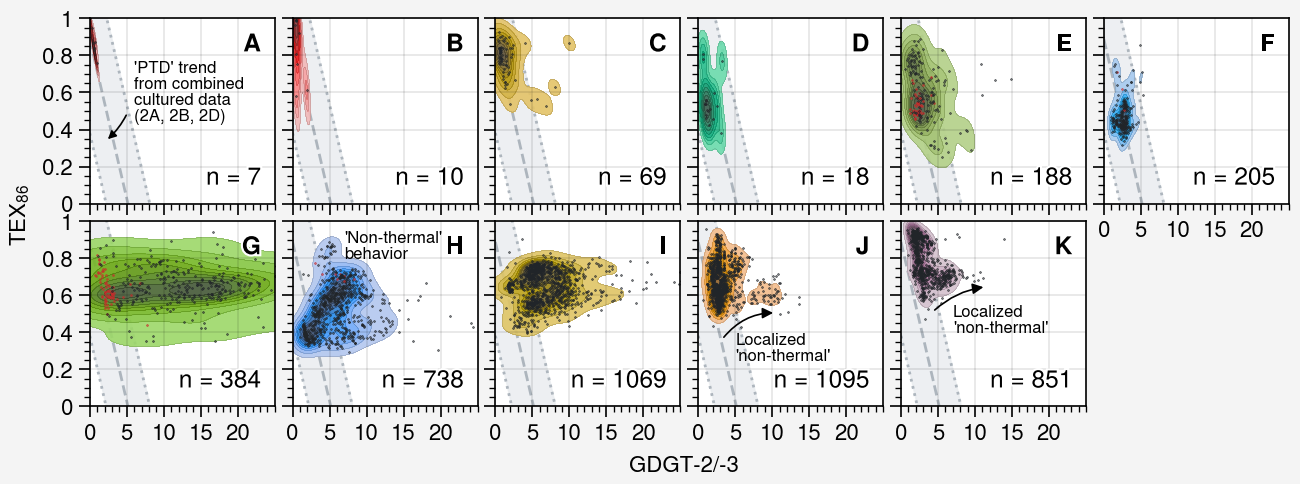

In [26]:
a = fig2_mainText_PNAS_MarineAOA()

### Figure 2. Thermal and non-thermal behaviors of isoGDGTs from different archives. 
Figure caption:
> Fig. 2 Thermal and non-thermal behaviors of GDGTs from different archives. (A-K) Scatter plots of GDGT-2/-3 ratios versus TEX86 and (L-V) their normalized KDE of orthogonal distances from the PTD trend (ODPTD). The order and colors of all subplots correspond to Fig. 1. GDGTs derived from (A) Cultures of thermophilic Crenarchaeota, (B) pure cultures of thermophilic AOA, (C) hot spring mats, (D) cultures of shallow-water AOA, (E) shallow SPM, and (F) shallow core-top sediments follow the PTD trend. GDGTs from (G) deep SPM and (H) deep core-top sediments show trends that deviate from the PTD trend. Samples from the (K) Mesozoic and the (J) Early Cenozoic also largely follow the PTD trend, while the (I) Late Cenozoic pattern resembles modern deep sediments and SPM. Red dots in 2E, 2F, 2G and 2H are data from the South China Sea (SCS). Contour plots of joint KDE (shaded, colored regions in A-K) are plotted with a contour interval of 0.1 from the joint density of 0.1 (outer rim) to 0.9 (core). Dashed gray lines in all subplots show the established PTD trend. Shaded gray areas represent ranges of ODPTD that approximately follow ‘thermal’ (0 ≤ ODPTD ≤ 1.0) behaviors. In L-V, normalized KDE values of 1 indicate the highest probability density at the corresponding ODPTD values. The dash-line curve in subplot R shows the normalized KDE when also including the SCS dataset.

In [27]:
### Regression of combined cultured data (gdgt23ratio on TEX86)
# data = df_nonIPL_hs[df_nonIPL_hs.dataType_level3=='Culture - Hot spring'].dropna(how='any',subset=['TEX86','gdgt23ratio'])
selected_data = pd.concat([df_nonIPL[df_nonIPL.dataType_level1=='Culture - AOA'][df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs[df_nonIPL_hs.dataType_level0=='Culture']]).dropna(how='any',subset=['TEX86','gdgt23ratio'])
data = selected_data.reset_index()

X = np.expand_dims(data.TEX86,axis=1)
y = np.array(data.gdgt23ratio)

import statsmodels.api as sm
X2 = sm.add_constant(X)
regress_model=sm.OLS(y,X2)
result=regress_model.fit()
print(result.summary())
print("P-value: ",result.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     21.02
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           6.24e-05
Time:                        17:20:34   Log-Likelihood:                -31.144
No. Observations:                  35   AIC:                             66.29
Df Residuals:                      33   BIC:                             69.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7297      0.376      7.254      0.0

### **4.2.3 Figure 3 in main text**

In [28]:
def fig3_mainText_PNAS_MarineAOA_revised():
    import warnings
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm
    
    warnings.filterwarnings('ignore')

    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    new_rc_params = {'text.usetex': False,
    "svg.fonttype": 'none'
    }
    plot.rc.update({'fontsize': 9,'fontname': 'Tex Gyre Heros','text.labelsize':9,})
    pycno_label_name = {
        'Shallow SPM':'Shallow',
        'Deep SPM':'Deep',
        'Shallow core tops':'Shallow',
        'Deep core tops':'Deep'
    }
    array = [[1,3,4,5],
            [2,3,4,5]]
    


    # Create a subplot with 1 row and 2 columns
    fig, axs = plot.subplots(array=array,figsize=(10,2.5),sharex=False,sharey=False,
                             wratios=[1,1,1,1],hspace='1em',
                             wspace=['7em','5em','5em'],
                            )
    
    ################################################################################################
    ##### This section is to calculate BIC and SS for IPL dataset #################################
    selected_data2 = df_IPL[df_IPL.QC_Indices_check=='Pass']
    selected_data2 = selected_data2[((selected_data2.dataType_level1=='Water-column SPM')
                          &(selected_data2.Site_edited!='South China Sea'))]
    selected_data2 = selected_data2.dropna(how='any',subset=['gdgt23ratio','TEX86'])
    selected_data2 = selected_data2.reset_index()
    
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.4242141432
    intercept_PTD = 1.1579773469
    
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)
    selected_data2['OrthoDist_from_PTD'] = abs(a*selected_data2.gdgt23ratio+(b*selected_data2.TEX86)+c)/np.sqrt(a*a+b*b)
    
    selected_data2 = selected_data2.dropna(how='any',subset=['OrthoDist_from_PTD'])
    selected_data2 = selected_data2.reset_index()
    selected_data2 = selected_data2.drop(columns=['index'])

    features2=['gdgt23ratio','TEX86']
    selected_data_unscaled = selected_data2[features2]
    
    range_n_clusters = np.arange(1,10,1)
    
    X2 = selected_data_unscaled
    silhouette_avg2=[]
    BIC2 = []
    
    
    
    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value
        clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full',
                                            n_init=20,random_state=1).fit(X2)
        cluster_labels = clusterer.predict(X2)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        if n_clusters == 1:
            sil_avg = np.nan
        else:
            sil_avg = silhouette_score(X2, cluster_labels,metric='mahalanobis')

        bic = clusterer.bic(X2)
        silhouette_avg2.append(sil_avg)
        BIC2.append(bic)

    #################################################################################################

    selected_data = df_nonIPL[df_nonIPL.QC_Indices_check=='Pass']
    selected_data = selected_data[((selected_data.dataType_level1=='Water-column SPM')
                          &(selected_data.Site_edited!='South China Sea'))]
    selected_data = selected_data.dropna(how='any',subset=['gdgt23ratio','TEX86'])
    selected_data = selected_data.reset_index()

    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.4242141432
    intercept_PTD = 1.1579773469
    
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)
    selected_data['OrthoDist_from_PTD'] = abs(a*selected_data.gdgt23ratio+(b*selected_data.TEX86)+c)/np.sqrt(a*a+b*b)

    selected_data = selected_data.dropna(how='any',subset=['OrthoDist_from_PTD'])
    selected_data = selected_data.reset_index()
    selected_data = selected_data.drop(columns=['index'])

    features2=['gdgt23ratio','TEX86']
    selected_data_unscaled = selected_data[features2]
    
    n_clusters_plot = [2,2]


    sns.set_palette('tableau')
    plot.rc.cycle = 'tableau'
    range_n_clusters = np.arange(1,10,1)
    
    X = selected_data_unscaled
    silhouette_avg=[]
    BIC = []

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value
        clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full',
                                            n_init=20,random_state=1).fit(X)
        cluster_labels = clusterer.predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        if n_clusters == 1:
            sil_avg = np.nan
        else:
            sil_avg = silhouette_score(X, cluster_labels,metric='mahalanobis')

        bic = clusterer.bic(X)
        silhouette_avg.append(sil_avg)
        BIC.append(bic)

        if n_clusters==n_clusters_plot[0]:
            cl_weights, cl_means, cl_covars = clusterer.weights_, clusterer.means_, clusterer.covariances_
            selected_data['cluster'] = cluster_labels
            
            ax1 = axs[2]
            ax1.format(
                abc=True,abcloc='lr',abcstyle='A'
            )

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 
            ax1.set_xlim([-0.2, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", np.round(sil_avg,decimals=4))

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()
                ith_cluster_silh_mean = ith_cluster_silhouette_values.mean()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                cmap = plot.Colormap('tableau')
                color = cmap(float(i) /10)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                ax1.text(0.8, y_lower + 0.5 * size_cluster_i, str(np.round(ith_cluster_silh_mean,3)))

                # Add middle line for each silhouette plot
                ax1.axhline(y_lower + (0.5 * size_cluster_i),0.1,color='gray5',ls='--')

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the value
            ax1.axvline(x=sil_avg, color="red", linestyle="--")
            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        else:
            continue

    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[4]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )


    ############################################################################################
    grouped_cluster = selected_data.groupby(selected_data.cluster)
    for name, group in grouped_cluster:

        data2 = group


        ax = axs[3]

        sns.kdeplot(x=data2.gdgt23ratio,y=data2.TEX86,ax=ax,
                    shade=True,thresh=0.05,color=colors_GMM_mapping.get(name),
                    levels=np.arange(0.1,1.1,0.1),
                    alpha=0.5,lw=0,zorder=2
                   )

        ax.format(
            abc=True,abcloc='lr',abcstyle='A',
            yticks=np.arange(0,1.2,0.2),
            yticklabels=None,
            xreverse=False,
            ylim=(0,1),
            xlim=(0,50),
            xticks=np.arange(0,55,10),
            xlabel='GDGT-2/-3',
            ylabel=r'$TEX_{86}$'
        )

        ax.grid(True)

        ax = axs[4]
        ax.scatter(data2.WOA18_decav_insituS,data2.WOA18_decav_insituT,marker='.',alpha=1,zorder=2,color=colors_GMM_mapping.get(name))
    
    ax = axs[3]
    ######################################################################################################
    #### Calculated centers of each cluster on the real dimension
    v1_mean = np.array(selected_data['gdgt23ratio'].groupby(selected_data.cluster).mean())
    v2_mean = np.array(selected_data['TEX86'].groupby(selected_data.cluster).mean())
    v3_mean = np.array(selected_data['OrthoDist_from_PTD'].groupby(selected_data.cluster).mean())
    realvalue_centers = np.transpose(np.vstack([v1_mean,v2_mean,v3_mean]))
    ###################################################################################################  
    #########################################

    # Labeling the clusters
    centers = realvalue_centers


    # Draw white circles at cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k',zorder=4)

    for i, c in enumerate(centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k',zorder=5)

    #########################################
    ##### Envelop of the pycnocline separation (not GMM clustering)
    ax = axs[3]
    grouped_pycno = selected_data.groupby(selected_data.dataType_level3)
    for name, gr_pycno in grouped_pycno:
        x = gr_pycno.gdgt23ratio
        y = gr_pycno.TEX86
        
        if 'Shallow' in pycno_label_name.get(name):
            sns.kdeplot(x=x,y=y,shade=False,thresh=0.05,levels=[0.1],ls='--',
                        color='k',
                        zorder=3,
                        ax=ax)

            x1, y1, x2, y2 = 5,0.80,12,0.85
            ax.annotate('Above Pycnocline\n     (Dash line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )
        elif 'Deep' in pycno_label_name.get(name):
            print(pycno_label_name.get(name))
            sns.kdeplot(x,y,shade=False,thresh=0.05,levels=[0.1],ls='dotted',
                        color='k',
                        zorder=3,
                        ax=ax)
    #         ax.scatter(x,y,marker='.',s=5,
    #                    color='k',
    #                   )
            x1, y1, x2, y2 = 10,0.4,12,0.1
            ax.annotate('Below Pycnocline\n(Dotted line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=8,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )

    ####################################################################################################### 
    ##### Plotting Silhouette Scores and BIC curves
    ax = axs[0]
    ax.plot(range_n_clusters,silhouette_avg,marker='o',color='k',zorder=2)

    ax2 = ax.twinx()
    ax2.plot(range_n_clusters,BIC,marker='o',ls='--',color='0.5',zorder=1)
    
    ax.format(
        xticks=np.arange(1,10,1),
        xtickminor=[],
        ylim=(0,0.5),
        ylabel=None,
        xticklabels=[],
    )

    ax2.format(
        ytickcolor='gray5',
        ylabel='BIC',
        ylim=(2400,3000)
    )
    ###
    #############################################################################################
    ##### This section is to plot BIC and SS for IPL dataset #################################
    ax = axs[1]
        
    ax.plot(range_n_clusters,silhouette_avg2,marker='o',color='k',zorder=2)

    ax2 = ax.twinx()
    ax2.plot(range_n_clusters,BIC2,marker='o',ls='--',color='0.5',zorder=1)

    ax.format(
        xticks=np.arange(1,10,1),
        xtickminor=[],
        ylim=(0,0.5),
        ylabel='Silhouette Score (SS)'
    )
        
    ax2.format(
        ytickcolor='gray5',
        ylabel='BIC',
        ylim=(1000,1300)
    )
   

    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[4]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )

    


    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    
    theta = np.arctan(float(coef_PTD))
    
    ### the numerator for intercept is the OD_PTD cut-off determined from Fig. S2
    intercept_OD = 0.5/np.cos(theta)
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    PTD_Line = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    plot_axes = [3]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,PTD_Line,
             zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            xlim=(0,50)
        )

    plot_axes = [0,1]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(
            abc=True,abcstyle='A',abcloc='ur'
        )

    # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
    filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\main-text\\"
    filename = 'fig3_PNAS_SPM_GMM_revised.pdf'
    fig.savefig(filepath+filename,api=330,bbox_inches='tight')

    plt.show()
    return selected_data

For n_clusters = 2 The average silhouette_score is : 0.2584
Deep


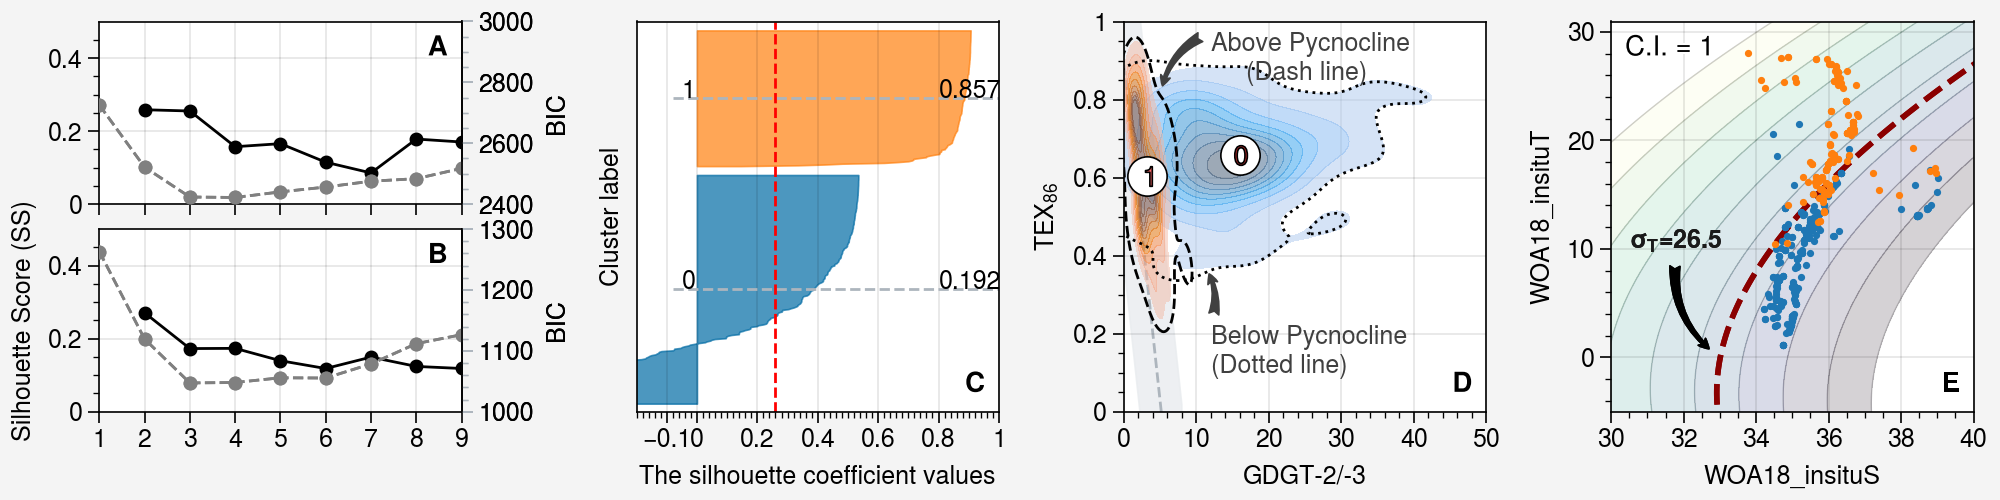

In [29]:
##Run fig3_mainText_PNAS_MarineAOA() below first
total_GDGT_SPM = fig3_mainText_PNAS_MarineAOA_revised()

### Figure 3. Clustering Analysis of modern SPM based on Gaussian Mixture Model (GMM) clustering algorithm
Figure caption:
> Fig. 3 Clustering Analysis of modern SPM based on Gaussian Mixture Model (GMM) algorithm. The consensus number of clusters (K) is 2. (A) Average silhouette scores (SS) based on Mahalanobis Distance (MD) and Bayesian Information Criterion (BIC) for K=1 to K=9. (B) Silhouette plots of the two resulting clusters. Horizontal gray lines show average SS of each cluster. A vertical red line shows the average SS for the entire dataset. (C) Contour plots of joint KDE for cluster 0 (C0; blue) and cluster 1 (C1; orange) with a contour interval of 0.1, from KDE = 0.1 to 0.9. The distribution pattern of the two clusters resembles the “shallow” and “deep” groups as shown in Figs. 2E and 2G. (G) Density contours (σT on p-t-s diagram) suggest C1 and C0 reflect “shallow” (less dense) and “deep” (denser) water masses, respectively. Subplots (H) to (N) represent the SPM IPL-GDGT dataset. MED = Mediterranean Sea. 

### **4.2.4 Figure 4 in main text**

In [30]:
def fig4_mainText_PNAS_marineAOA_revised():
    rc_params = {
        'fontsize': 8,
        'fontname': 'Tex Gyre Heros',
        'text.labelsize':8,
        'axes.labelpad':2
    }
    plot.rc.update(rc_params)

    array = [
        [1,1,0,0,0],
        [2,3,6,6,6],
        [0,0,7,7,7],
        [4,5,8,8,8],
    ]
    fig, axs = plot.subplots(array,
                            figsize=(9,5),
                            hratios=(0.25,1,0.25,1),
                            wspace=('2em','5em','0em','0em'),hspace=('5em','0em','0em'),
                            sharey=False,spany=False,
                            sharex=False,spanx=False
                            )

    paleoData = df_nonIPL[df_nonIPL.dataType_level0=='Ancient'][df_nonIPL.QC_Indices_check=='Pass']#[df_nonIPL.paleoWaterDepth>=1000]

    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311

    # Function to find distance 
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)


    paleoData['OrthoDist_from_PTD'] = abs(a*paleoData.gdgt23ratio+(b*paleoData.TEX86)+c)/np.sqrt(a*a+b*b)
    selected_data = paleoData.dropna(how='any',subset=['gdgt23ratio','TEX86','sampleAge',
                                                        'paleolat','paleolon','paleoWaterDepth',
                                                       'OrthoDist_from_PTD',
                                                    ])
    selected_data = selected_data.reset_index()
    selected_data = selected_data.drop(columns=['index'])
    
    #Pre-processing data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    features2=['gdgt23ratio','TEX86']
    df4 = scaler.fit_transform(selected_data[features2])
    selected_data_scaled = pd.DataFrame(df4,columns=features2)
    selected_data_unscaled = selected_data[features2]

    from sklearn.cluster import KMeans
    from sklearn import mixture
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.cm as cm
    sns.set_palette('tableau')
    plot.rc.cycle = 'tableau'
    range_n_clusters = np.arange(1,11,1)
    X = selected_data_unscaled
    silhouette_avg=[]
    BIC=[]

    plot_n_clusters = 2

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
    #     clusterer = KMeans(n_clusters=n_clusters, random_state=1)
        clusterer = mixture.GaussianMixture(n_components=n_clusters,covariance_type='full',random_state=1,n_init=20).fit(X)
        cluster_labels = clusterer.fit_predict(X)
        
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        if n_clusters == 1:
            sil_avg = np.nan
        else:
            sil_avg = silhouette_score(X, cluster_labels,metric='mahalanobis')
        silhouette_avg.append(sil_avg)
        BIC.append(clusterer.bic(X))
        
        
        if n_clusters==plot_n_clusters:
            gmm_weights = clusterer.weights_
            gmm_means = clusterer.means_
            gmm_covars = clusterer.covariances_
            
            selected_data['cluster'] = cluster_labels
            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", np.round(sil_avg,decimals=4))
    


        else:
            continue

###### Switching clusters if needed ##################################################################
    print(selected_data.cluster.unique())
    selected_data.cluster = selected_data.cluster.replace({0:'1',1:'0'})
    print(selected_data.cluster.unique())
            
            
######################################################################################################
#### Calculated centers of each cluster on the real dimension
    v1_mean = np.array(selected_data['gdgt23ratio'].groupby(selected_data.cluster).mean())
    v2_mean = np.array(selected_data['TEX86'].groupby(selected_data.cluster).mean())
    realvalue_centers = np.transpose(np.vstack([v1_mean,v2_mean]))

################################################################################################################   
    ax2 = axs[1]
    grouped2 = selected_data.groupby(selected_data.cluster)

    for name2, group2 in grouped2:     
        # 2nd Plot showing the actual clusters formed
        ax2.scatter(group2['gdgt23ratio'], group2.TEX86, marker='.', s=5, lw=0, alpha=0.7,
                    c=colors_GMM_mapping.get(name2))

    ax2.format(
        urtitle=r"$\it{K}$ = 2"
    )   
    # Labeling the clusters
#     centers = clusterer.cluster_centers_
    centers = realvalue_centers


    # Draw white circles at cluster centers

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

#         ax2.set_title("GDGT-2/-3 vs. TEX86")
    ax2.set_xlabel('')
    ax2.set_ylabel(r"$TEX_{86}$")
    ax2.format(
        ltitle='GMM of paleo-GDGTs',
        ylim=(0,1),
        xlim=(0,25),
        xticks=np.arange(0,30,5),
    )



    ### Plotting data into different group
    grouped = selected_data.groupby(selected_data.dataType_level3)
    plot_axes = {
        'Late Cenozoic':2,
        'Early Cenozoic':3,
        'Mesozoic':4
    }
    for name, group in grouped:
        cmap = plot.Colormap('tableau')
        colors2 = cmap(group.cluster.astype(float) / 10)
        ax = axs[plot_axes.get(name)]
        ax.scatter(group.gdgt23ratio,group.TEX86,color=colors2,marker='.', s=5, lw=0, alpha=0.7,)
        if plot_axes.get(name) == 3:
            ax.format(
            rtitle=name,
            ylim=(0,1),
            xlim=(0,25),
            xticks=np.arange(0,30,5),
            xlabel='',
            )
        else:
            
            ax.format(
                rtitle=name,
                ylim=(0,1),
                xlim=(0,25),
                xticks=np.arange(0,30,5),
                xlabel='',
                ylabel='',
                yticklabels=[]
            )
        ax.fill_between((15,25),1,0.95,color=colors_mapping.get(name),edgecolor='0.5',alpha=1)    

    ###########################################################################
    ax = axs[0]
    ax.plot(range_n_clusters,silhouette_avg,marker='o',color='k',zorder=2)

    ax2 = ax.twinx()
    ax2.plot(range_n_clusters,BIC,marker='o',ls='--',color='0.5',zorder=1)
    # ax2.plot(range_n_clusters,AIC,marker='o',ls='--',zorder=0)

    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        xticks=np.arange(1,11,1),
        xtickminor=[],
        xlabel='Number of clusters (k)',
        ylabel='SS',
    #     ylim=(0,1)
    )
    ax2.format(
        ytickcolor='gray6',
        ycolor='gray8',
        ylabel='BIC'
    )
    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    
    theta = np.arctan(float(coef_PTD))
    intercept_OD = 0.5/np.cos(theta)
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    PTD_Line = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    plot_axes = [1,2,3,4]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,PTD_Line,
             zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            abc=True,abcstyle='A',abcloc='lr',
            xlim=(0,25)
        )
    ##########################################################################
    ##########################################################################
    ##########################################################################
    ax = axs[5]

    grouped2 = selected_data.groupby(selected_data.cluster)
    ii=0
    for name2, group2 in grouped2:
        ax.scatter(group2.sampleAge,  group2.gdgt23ratio, marker='.', s=5, lw=0, alpha=0.7,
                        color=colors_GMM_mapping.get(name2))
        binsize=5
        paleoData_rollmean = rollmean_calculation_step(group2,'gdgt23ratio',0,200,binsize)
        ax.step(paleoData_rollmean[:,0],paleoData_rollmean[:,2],
                color=colors_GMM_mapping.get(name2),lw=0.5,where='post')
        ax.fill_between(paleoData_rollmean[:,0],paleoData_rollmean[:,5],paleoData_rollmean[:,6],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.1)
        ax.fill_between(paleoData_rollmean[:,0],paleoData_rollmean[:,3],paleoData_rollmean[:,4],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.3)
        ii += 1
    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        ylabel='GDGT-2/-3',
        ylim=(0,35),
        yticks=np.arange(0,21,5),
        ytickrange=(0,20),
        xlim=(0,200),
        xticks=np.arange(0,205,10),
        xticklabels=[]
    )

    ax = axs[6]
    sns.kdeplot(data=selected_data,x='sampleAge',hue="cluster",multiple='fill',legend=False,ax=ax,
               color=colors_GMM_mapping)
    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        ylabel='Density',
        xlim=(0,200),
        xticks=np.arange(0,205,10),
        xticklabels=[]
    )

    ax = axs[7]
    ii=0
    for name2, group2 in grouped2:
        ax.scatter(group2.sampleAge,  group2.paleoWaterDepth, marker='.', s=5, lw=0, alpha=0.7,
                        color=colors_GMM_mapping.get(name2))
        binsize=5
        paleoDepth_rollmean = rollmean_calculation_step(group2,'paleoWaterDepth',0,200,binsize)
        ax.step(paleoDepth_rollmean[:,0],paleoDepth_rollmean[:,2],
                color=colors_GMM_mapping.get(name2),lw=0.5,where='post')
        ax.fill_between(paleoDepth_rollmean[:,0],paleoDepth_rollmean[:,5],paleoDepth_rollmean[:,6],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.1)
        ax.fill_between(paleoDepth_rollmean[:,0],paleoDepth_rollmean[:,3],paleoDepth_rollmean[:,4],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.3)
        ii += 1
    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        ylabel='Paleo water depth (mbsl)',
        ylim=(-2000,7000),
        yticks=np.arange(0,5100,1000),
        ytickrange=(0,5000)
    )

    ldf = gts.data.loc[gts.data.Level == "Period", :]
    ageName = ldf.Name
    ageStart = ldf.Start
    ageEnd = ldf.End
    ageMean = ldf.MeanAge
    ageColor = ldf.Color

    for i in range(len(ldf.Name[:5])):

        h = 800
        w = ageStart[i] - ageEnd[i]
        y = 6200
        x = ageEnd[i]
        xy = (x,y)
        
        rect = Rectangle(xy,w,h,
                        facecolor=ageColor[i],
                        edgecolor="k")
        ax.add_artist(rect)
        if ageName[i] == "Quaternary":
            continue
        else:        
            ax.text(ageMean[i]-9,y+(h/1.25),ageName[i],
                fontname='TeX Gyre Heros',
                rotation=0)

    ldf = gts.data.loc[gts.data.Level == "Epoch", :]
    ageName = ldf.Epoch
    ageStart = ldf.Start
    ageEnd = ldf.End
    ageMean = ldf.MeanAge
    ageColor = ldf.Color
    eraName = ldf.Era
    for i in range(len(ldf.Name[:12])):

        h = 800
        w = ageStart[i] - ageEnd[i]
        y = 5400
        x = ageEnd[i]
        xy = (x,y)
        
        rect = Rectangle(xy,w,h,
                        facecolor=ageColor[i],
                        edgecolor="k")
        ax.add_artist(rect)
        if eraName[i] == "Mesozoic":
            if ageName[i] == "Middle":
                ax.text(ageMean[i]-4,y+(h/1.25),ageName[i][0:3]+'.',fontname='TeX Gyre Heros',
                    rotation=0) 
            elif ageName[i] == "Lower":
                ax.text(ageMean[i]-4,y+(h/1.25),'Early',fontname='TeX Gyre Heros',
                    rotation=0)
            elif ageName[i] == "Upper":
                ax.text(ageMean[i]-4,y+(h/1.25),'Late',fontname='TeX Gyre Heros',
                    rotation=0)    
            else:
                ax.text(ageMean[i]-4,y+(h/1.25),ageName[i],fontname='TeX Gyre Heros',
                    rotation=0)
        elif ((ageName[i] == "Pliocene")|(ageName[i] == "Pleistocene")|(ageName[i] == "Holocene")):
            continue
        else:        
            ax.text(ageMean[i]-4,y+(h/1.25),ageName[i][0:3]+'.',
                fontname='TeX Gyre Heros',
                rotation=0)    


    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        yreverse=True,
        xlim=(0,200),
        xticks=np.arange(0,205,10),
        xtickloc='bottom',
        xlabel="Age (Million years ago, Ma)",
    )
    axs[3].text(22,-0.2,'GDGT-2/-3')
    # axs[3].format(
    #     yticklabels=np.arange(0,1.2,0.2),
    #     ylabel=r'TEX$_{86}$'
    # )

    plt.show()
    filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
    filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\main-text\\"   
    filename = 'fig4_PNAS_GDGT_GMM_overTime_revised.pdf'
    fig.savefig(filepath+filename,api=330)


For n_clusters = 2 The average silhouette_score is : 0.2657


KeyboardInterrupt: 

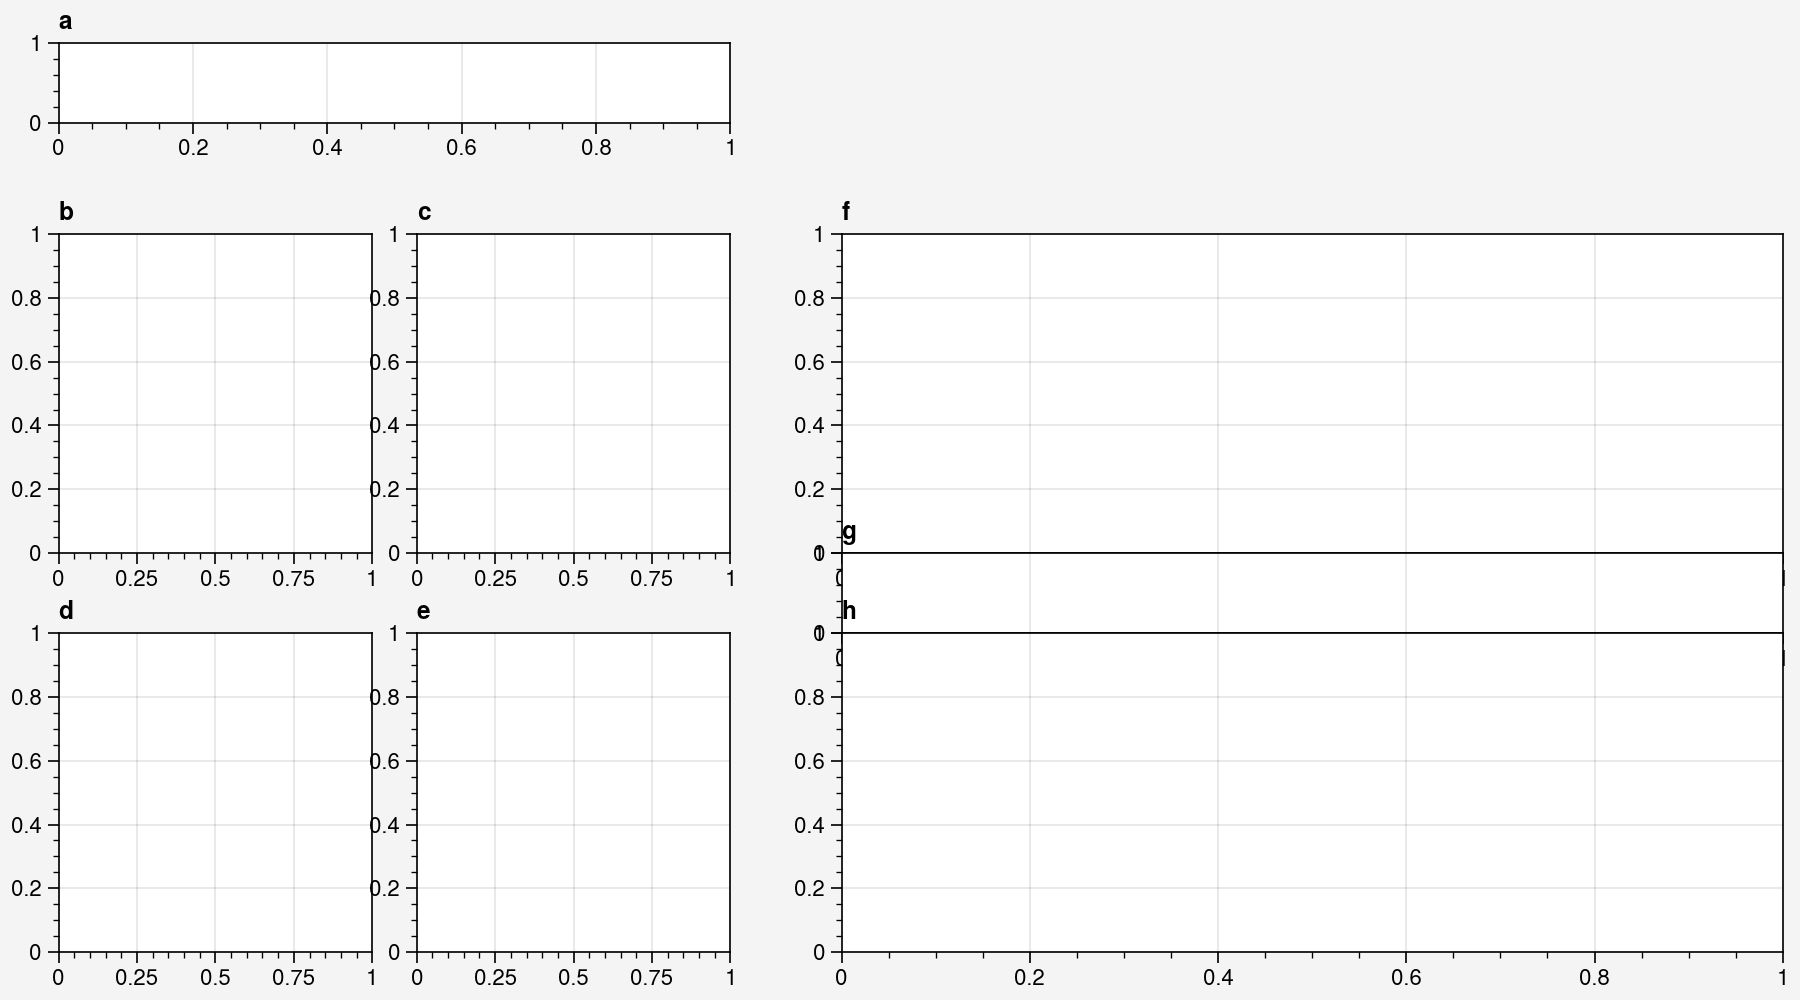

In [31]:
fig4_mainText_PNAS_marineAOA_revised()

### Figure 4. Clustering Analysis of paleo lipid biomarkers and the evolution of recognized clusters over the past 192 million years
Figure caption:
> Fig. 4. Clustering Analysis of paleo lipid biomarkers and the evolution of recognized clusters over the past 192 million years. (A) MD-based SS and BIC plots show that the optimal number of clusters (K) is 2; the strongest improvement of BIC and the highest SS. (B) The GMM clustering results where K=2. Cluster 1 (orange, C1) exhibits ‘thermal’ behavior pattern while Cluster 0 (blue, C0) shows ‘non-thermal’ behavior pattern deviating from the established PTD trend based on combined cultured datasets (dash line). Scatter plots of resulting clusters during each geologic time interval including (C) late Cenozoic, (D) early Cenozoic, and (E) Mesozoic show changes in distribution patterns over time. (F) Evolution of GDGT-2/-3 over geologic time scale for C0 and C1 with 2-myr binned values including medians (middle lines), interquartile range (darker shaded boxes), and min-max range (lighter shaded boxes). (G) Proportion of data density between C0 and C1 based on kernel density estimates. (H) Paleo water depth estimates based on a series of paleogeographic maps from PaleoDEMS project. Note: Labeled major climatic and oceanic anoxic events with relative ice volumes are modified from Westerhold et al. (2021) and Grossman & Joachimski (2020).

## **4.3 Supplementary figures**

### **4.3.1 Figure S1 - Presumed Temperature Dependent (PTD) trend establishment**

In [ ]:
pd.set_option('display.max_rows',4,'display.max_columns',10)
frames = [df_nonIPL[df_nonIPL.dataType_level1 == 'Culture - AOA'][df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs]
sel_PTD = pd.concat(frames)
sel_PTD

In [ ]:
import statsmodels.api as sm
from scipy.odr import *

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
array = [[1,2,2]]
fig, axs = plot.subplots(array,figsize=(7,2.8),share=False,wspace='1em')
axs.format(abc=False,abcstyle='A',abcloc='lr',
           # suptitle='PTD trend based on combined culture data',
           xlim=(0,25),ylim=(0,1),
           xticks=np.arange(0,26,5),
           xlabel='GDGT-2/-3',
           ylabel='TEX$_{86}$'
           )


ax = axs[0]
data = selected_data[['gdgt23ratio','TEX86']].dropna(how='any')

sns.kdeplot(x=data.gdgt23ratio,y=data.TEX86,ax=ax,
                shade=True,thresh=0.05,levels=10,bw_adjust=1,linewidth=0.5,color='grey5',alpha=0.5,zorder=0)

################# Start Ordinary Least Square (OLS) Regression #################
Y = np.expand_dims(data.TEX86,axis=1)
X = np.expand_dims(data.gdgt23ratio,axis=1)

x = np.array(data.gdgt23ratio)
y = np.array(data.TEX86)

# X2 = sm.add_constant(X)


reg = linear_model.LinearRegression()
#### Reverse OLS ####
reg.fit(Y,x)

line_Y_extended = np.arange(0,1.1,0.1)[:, np.newaxis]
line_x_extended = reg.predict(line_Y_extended)
ax.plot(line_x_extended,np.squeeze(line_Y_extended),zorder=0,color='grey7',ls=':',lw=1)

coef_inv = np.round(reg.coef_,3)
new_intercept = np.round(reg.intercept_,3)
score = np.round(reg.score(Y,x),3)
# axs[1].text(5,0.45,f'y = {coef_inv[0]}x+{new_intercept}',c="k",fontsize=8)
# axs[1].text(5,0.35,r"$r^{2}$ = "+f'{score}',c="k",fontsize=8)

#### Direct OLS ####
reg.fit(X,y)

line_X = np.arange(0,25)[:,np.newaxis]
line_y = reg.predict(line_X)
ax.plot(np.squeeze(line_X),line_y,color='grey7',ls='--',lw=1,zorder=1)



################# Start Orthogonal Distance Regression (ODR) #################
# Create a model for fitting.
linear_model2 = Model(linear_func)

# Create a RealData object using our initiated data from above.
data_odr = RealData(data.gdgt23ratio,data.TEX86)

# Set up ODR with the model and data.
odr = ODR(data_odr, linear_model2, beta0=[0., 1.])

# Run the regression.
out = odr.run()

slope = out.beta[0]
intercept = out.beta[1]

X_ODR = np.array([0,6])
Y_ODR = np.array([(i*slope + intercept) for i in X_ODR])
ax.plot(X_ODR,Y_ODR,lw=2,color='k',zorder=1)


df_stats = data.gdgt23ratio.count() - 2  # equivalently, df = odr_out.iwork[10]
beta_0 = 0  # test if slope is significantly different from zero
t_stat = (out.beta[0] - beta_0) / out.sd_beta[0]  # t statistic for the slope parameter
p_val = stats.t.sf(np.abs(t_stat), df_stats) * 2
print('ODR equation axs[3]: y={:3.3f}x + {:3.3f}, t={:3.3f}, p={:.3e}'.format(out.beta[0], out.beta[1], t_stat, p_val))
print('ODR r-square: ',1-(out.sum_square_eps/(np.sum((data.TEX86 - data.TEX86.mean())**2))))
print("-------------------------------")

ax.text(6,0.38,f'y = {np.round(out.beta[0],3)}x+{np.round(out.beta[1],3)}',c="k",fontsize=10,fontweight='bold')
ax.text(6,0.32,r"($r^{2}$ = 0.423; p = 3.543x$10^{-5}$)",c="k",fontsize=8,fontstyle='italic')
################# End Orthogonal Distance Regression #################


############################################################################
selected_data = pd.concat([df_nonIPL[df_nonIPL.dataType_level1=='Culture - AOA'][df_nonIPL.QC_Indices_check=='Pass'],
                           df_nonIPL_hs[df_nonIPL_hs.dataType_level0=='Culture']])
selected_data = selected_data.reset_index()
grouped = selected_data.groupby(selected_data.dataType_level3)
rename_dict = {'Culture - AOA':"Shallow AOA cultures",
               'Culture - ThAOA':"ThAOA cultures",
               'Culture - Hot spring':r"Thermoproteia cultures"
              }
for name, group in grouped:
    name2 = rename_dict.get(name)
    ax.scatter(group.gdgt23ratio,group.TEX86,marker='.',markersize=30*5,markeredgecolor='k',color=colors_mapping.get(name),zorder=2,label=name2)

# sns.kdeplot(data.gdgt23ratio,data.TEX86,levels=10,zorder=0,shade=True,color='grey')
ax.format(
    xlim=(0,20),
    ylim=(0,1)
)
h, l = ax.get_legend_handles_labels()
ax.legend(h,loc='ur',ncols=1,frameon=True)

ax = axs[1]
ax.format(
    ultitle='Summary of Linear Regression Techniques',
    grid=False,
    xlabel='',
    ylabel='',
    xticklabels=[],
    yticklabels=[],
    xticks=[],
    yticks=[]
)

# filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/Supplementary_figures/"
# filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"  
# filename = 'figS1_PTD trend_revised_forFinalRevision.pdf'
# fig.savefig(filepath+filename,api=330)

In [ ]:
import statsmodels.api as sm
from scipy.odr import *

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c


array = [[1,2,5,5],
         [3,4,5,5]]

fig, axs = plot.subplots(array,width=7)
axs.format(abc=True,abcstyle='A',abcloc='lr',
           suptitle='Linear regressions comparison for establishing PTD trend',
           xlim=(0,25),ylim=(0,1),
           xticks=np.arange(0,26,5),
           xlabel='GDGT-2/-3',
           ylabel='TEX$_{86}$'
           )
selected_data = pd.concat([df_nonIPL[df_nonIPL.dataType_level1=='Culture - AOA'][df_nonIPL.QC_Indices_check=='Pass'],
                           df_nonIPL_hs[df_nonIPL_hs.dataType_level0=='Culture']])
selected_data = selected_data.reset_index()
grouped = selected_data.groupby(selected_data.dataType_level3)


for name, group in grouped:
    i = plots_mapping.(name)

    if 'Culture - AOA' in name:
        i = i-1
        
    data_count=group.gdgt23ratio.count()
    data = group[['gdgt23ratio','TEX86']].dropna(how='any')
    
    ax = axs[i]
    ax.format(
        urtitle=name
    )

    sns.kdeplot(x=group.gdgt23ratio,y=group.TEX86,ax=ax,
                shade=True,thresh=0.05,levels=10,bw_adjust=1,linewidth=0,color=colors_mapping.get(name),alpha=0.7,zorder=0)
    
    Y = np.expand_dims(data.TEX86,axis=1)
    X = np.expand_dims(data.gdgt23ratio,axis=1)
    
    x = np.array(data.gdgt23ratio)
    y = np.array(data.TEX86)
    
    X2 = sm.add_constant(X)
    regress_model=sm.OLS(y,X2)
    result=regress_model.fit()
    
    print(f"Direct OLS of {name}")
    print(result.summary())
    print("P-value: ",result.pvalues)
    print("-------------------------------")
    
    
    Y2 = sm.add_constant(Y)
    regress_model=sm.OLS(x,Y2)
    result=regress_model.fit()
    
    print(f"Reverse OLS of {name}")
    print(result.summary())
    print("P-value: ",result.pvalues)
    print("-------------------------------")

    # reg = linear_model.RANSACRegressor(random_state=0)
    # reg = linear_model.TheilSenRegressor(random_state=0)
    # reg = linear_model.HuberRegressor()
    reg = linear_model.LinearRegression()
    
    #### Reverse OLS #####
    reg.fit(Y,x)
    line_Y = np.arange(Y.min(),Y.max())[:, np.newaxis]
    line_x = reg.predict(line_Y)
    ax.plot(line_x,np.squeeze(line_Y),zorder=0,color='red')

    line_Y_extended = np.arange(0,1.1,0.1)[:, np.newaxis]
    line_x_extended = reg.predict(line_Y_extended)
    ax.plot(line_x_extended,np.squeeze(line_Y_extended),zorder=0,color='r',ls='-',lw=1)
    # axs[4].plot(np.squeeze(line_X),line_y,color=colors_mapping.get(name),ls=':',lw=1,zorder=1)

    if 'RANSAC' in str(type(reg)):
        inlier_mask = reg.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        ax.scatter(x[inlier_mask],Y[inlier_mask],marker='.',color='k')
        ax.scatter(x[outlier_mask],Y[outlier_mask],marker='.',color='r')
      
        reg = linear_model.LinearRegression()
        reg.fit(Y[inlier_mask],x[inlier_mask])
        score = np.round(reg.score(Y[inlier_mask],x[inlier_mask]),3)
        coef_ThCren_round = np.round(float(reg.coef_),10)
        intercept_ThCren = np.round(float(reg.intercept_),10)
    else:
        ax.scatter(x,Y,marker='.',color='k')
        score = np.round(reg.score(Y,x),3)
        coef_ThCren_round = np.round(float(reg.coef_),10)
        intercept_ThCren = np.round(float(reg.intercept_),10)
    
    coef_inv = np.round(1/coef_ThCren_round,3)
    intercept_ThCren_round = np.round(intercept_ThCren,10)
    new_intercept = np.round((-intercept_ThCren_round/coef_ThCren_round),3)
    ax.text(5,0.65,f'y = {coef_inv}x+{new_intercept}',c="0.5",fontsize=8)
    ax.text(7,0.55,r"$r^{2}$ = "+f'{score}',c="0.5",fontsize=8)
    
    SSRE = np.sum((x - reg.predict(y[:, np.newaxis]))**2) ## Sum squared error of predicted x errors
    SSTE = np.sum((x - x.mean())**2)## Sum squared error of x from mean
    R_square = (1-(SSRE/SSTE))
    print(f"Reverse r-square of {name}: {R_square}") 

   
    #### Direct OLS ######
    X = np.expand_dims(data.gdgt23ratio,axis=1)
    y = np.array(data.TEX86)

    reg = linear_model.LinearRegression()
    reg.fit(X,y)

    line_X = np.arange(0,25)[:,np.newaxis]
    line_y = reg.predict(line_X)
    ax.plot(np.squeeze(line_X),line_y,color='k',ls='-',lw=1,zorder=1)
    # axs[4].plot(np.squeeze(line_X),line_y,color=colors_mapping.get(name),ls='-',lw=1,zorder=1)

    coef_inv = np.round(reg.coef_,3)
    new_intercept = np.round(reg.intercept_,3)
    ax.text(6,0.45,f'y = {coef_inv[0]}x+{new_intercept}',c="k",fontsize=8)
    ax.text(8,0.35,r"$r^{2}$ = "+f'{score}',c="k",fontsize=8)
    SSRE = np.sum((y - reg.predict(x[:, np.newaxis]))**2) ## Sum squared error of predicted y errors
    SSTE = np.sum((y - y.mean())**2)## Sum squared error of y from mean
    R_square = (1-(SSRE/SSTE))
    print(f"Direct r-square of {name}: {R_square}")     
    
    ################# Start Orthogonal Distance Regression #################
    # Create a model for fitting.
    linear_model2 = Model(linear_func)

    # Create a RealData object using our initiated data from above.

    data_odr = RealData(data.gdgt23ratio, data.TEX86)

    # Set up ODR with the model and data.
    odr = ODR(data_odr, linear_model2, beta0=[0., 1.])

    # Run the regression.
    out_subset = odr.run()

    slope = out_subset.beta[0]
    intercept = out_subset.beta[1]

    X_ODR = np.array([0,25])
    Y_ODR = np.array([(i*slope + intercept) for i in X_ODR])
    ax.plot(X_ODR,Y_ODR,zorder=0,lw=2,color='blue3')
    df_stats = data.gdgt23ratio.count() - 2  # equivalently, df = odr_out.iwork[10]
    beta_0 = 0  # test if slope is significantly different from zero
    t_stat = (out_subset.beta[0] - beta_0) / out_subset.sd_beta[0]  # t statistic for the slope parameter
    p_val = stats.t.sf(np.abs(t_stat), df_stats) * 2
    print(f'ODR equation {name}:', 'y={:3.3f}x + {:3.3f}, t={:3.3f}, p={:.3e}'.format(out_subset.beta[0], out_subset.beta[1], t_stat, p_val))
    print('ODR r-square: ',1-(out_subset.sum_square_eps/(np.sum((data.TEX86 - data.TEX86.mean())**2))))
    print("-------------------------------")
    ax = axs[4]
    # ax.plot(line_x_extended,np.squeeze(line_Y_extended),zorder=0,color=colors_mapping.get(name),ls='--',lw=1)
    ax.plot(X_ODR,Y_ODR,zorder=0,color=colors_mapping.get(name),ls='--',lw=1)


    

ax = axs[3]
ax.format(
    urtitle='Combined cultured data'
)
data = selected_data[['gdgt23ratio','TEX86']].dropna(how='any')

Y = np.expand_dims(data.TEX86,axis=1)
X = np.expand_dims(data.gdgt23ratio,axis=1)

x = np.array(data.gdgt23ratio)
y = np.array(data.TEX86)

X2 = sm.add_constant(X)
regress_model=sm.OLS(y,X2)
result=regress_model.fit()

print(f"Direct OLS of Combined culture data")
print(result.summary())
print("P-value: ",result.pvalues)
print("-------------------------------")


Y2 = sm.add_constant(Y)
regress_model=sm.OLS(x,Y2)
result=regress_model.fit()

print(f"Reverse OLS of Combined culture data")
print(result.summary())
print("P-value: ",result.pvalues)
print("-------------------------------")
################# Start Orthogonal Distance Regression #################
# Create a model for fitting.
linear_model2 = Model(linear_func)

# Create a RealData object using our initiated data from above.
data_odr = RealData(data.gdgt23ratio, data.TEX86)

# Set up ODR with the model and data.
odr = ODR(data_odr, linear_model2, beta0=[0., 1.])

# Run the regression.
out = odr.run()

slope = out.beta[0]
intercept = out.beta[1]

X_ODR = np.array([0,6])
Y_ODR = np.array([(i*slope + intercept) for i in X_ODR])
ax.plot(X_ODR,Y_ODR,zorder=0,lw=2,color='blue3')
axs[4].plot(X_ODR,Y_ODR,zorder=5,lw=2,color='k')

df_stats = data.gdgt23ratio.count() - 2  # equivalently, df = odr_out.iwork[10]
beta_0 = 0  # test if slope is significantly different from zero
t_stat = (out.beta[0] - beta_0) / out.sd_beta[0]  # t statistic for the slope parameter
p_val = stats.t.sf(np.abs(t_stat), df_stats) * 2
print('ODR equation axs[3]: y={:3.3f}x + {:3.3f}, t={:3.3f}, p={:.3e}'.format(out.beta[0], out.beta[1], t_stat, p_val))
print('ODR r-square: ',1-(out.sum_square_eps/(np.sum((data.TEX86 - data.TEX86.mean())**2))))
print("-------------------------------")
################# End Orthogonal Distance Regression #################



Y = np.expand_dims(data.TEX86,axis=1)
x = np.array(data.gdgt23ratio)

X = np.expand_dims(data.gdgt23ratio, axis=1)
y = np.array(data.TEX86)

# reg = linear_model.RANSACRegressor(random_state=1)
# reg = linear_model.TheilSenRegressor(random_state=2)
# reg = linear_model.HuberRegressor()
reg = linear_model.LinearRegression()


if 'RANSAC' in str(type(reg)):
    line_Y = np.arange(Y.min(),Y.max())[:, np.newaxis]
    line_x = reg.predict(line_Y)
    ax.plot(line_x,np.squeeze(line_Y),zorder=0,color='red')

    line_Y_extended = np.arange(0,1.1,0.1)[:, np.newaxis]
    line_x_extended = reg.predict(line_Y_extended)
    ax.plot(line_x_extended,np.squeeze(line_Y_extended),zorder=0,color='gray7',ls='--',lw=2)  
    inlier_mask = reg.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    ax.scatter(x[inlier_mask],Y[inlier_mask],marker='.',color='k')
    ax.scatter(x[outlier_mask],Y[outlier_mask],marker='.',color='r')

    reg = linear_model.LinearRegression()
    reg.fit(Y[inlier_mask],x[inlier_mask])
    line_Y2 = np.arange(0,1.1,0.1)[:, np.newaxis]
    line_x2 = reg.predict(line_Y2)
    ax.plot(line_x2,line_Y2)
    score = np.round(reg.score(Y[inlier_mask],x[inlier_mask]),3)
    coef_ThCren = np.format_float_positional(reg.coef_,sign=True,precision=10)
    intercept_ThCren = np.round(float(reg.intercept_),10)
else:
    #### GDGT-2/-3 on TEX86 (reverse); predict GDGT-2/-3 based on TEX86 values; assume error-free on TEX86
    reg.fit(Y,x)

    line_Y = np.arange(Y.min(),Y.max())[:, np.newaxis]
    line_x = reg.predict(line_Y)
    # ax.plot(line_x,np.squeeze(line_Y),zorder=0,color='red')

    line_Y_extended = np.arange(0,20)[:, np.newaxis]
    line_x_extended = reg.predict(line_Y_extended)

    ax.plot(line_x_extended,np.squeeze(line_Y_extended),zorder=1,color='r',ls='-',lw=1.)
    # axs[4].plot(line_x_extended,np.squeeze(line_Y_extended),zorder=1,color='gray9',ls='-',lw=1.)  
    ax.scatter(x,Y,marker='.',color='k')
    score = np.round(reg.score(Y,x),3)
    coef_ThCren = np.format_float_positional(reg.coef_,sign=True,precision=10)
    intercept_ThCren = np.round(float(reg.intercept_),10)
    
    #### TEX86 on GDGT-2/-3 (direct); predict TEX86 based on GDGT-2/-3 values; assume error-free on GDGT-2/-3
    reg.fit(X,y)
    line_X = np.arange(X.min(),X.max())[:,np.newaxis]
    line_y = reg.predict(line_X)
    
    line_X_extended = np.arange(0,20)[:,np.newaxis]
    line_y_extended = reg.predict(line_X_extended)
    ax.plot(line_X_extended,line_y_extended,c='k')

coef_ThCren_round = np.round(float(coef_ThCren),10)
coef_inv = np.round(1/coef_ThCren_round,3)
intercept_ThCren_round = np.round(intercept_ThCren,10)
new_intercept = np.round((-intercept_ThCren_round/coef_ThCren_round),3)
ax.text(5,0.65,f'y = {coef_inv}x+{new_intercept}',c="k",fontsize=8)
ax.text(7,0.55,r"$r^{2}$ = "+f'{score}',c="k",fontsize=8)

ax.text(8,0.38,f'y = {np.round(out.beta[0],3)}x+{np.round(out.beta[1],3)}',c="b",fontsize=8)
ax.text(10,0.28,r"($r^{2}$ = 0.423)",c="b",fontsize=8)



axs.format(
    xreverse=False
)
axs[4].format(
    xlim=(0,10)
)

# filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/Supplementary_figures/"
# filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"  
# filename = 'figS1_RegressionComparison_revised.pdf'
# fig.savefig(filepath+filename,api=330)

### **4.3.2 Figure S2 - Kernel Density Estimates (KDEs) of Orthogonal Distances from PTD trend**

In [ ]:
### Combined Culture Dataset
selected_data = pd.concat([df_nonIPL[df_nonIPL.dataType_level1=='Culture - AOA'][df_nonIPL.QC_Indices_check=='Pass'],
                           df_nonIPL_hs[df_nonIPL_hs.dataType_level0=='Culture']])
selected_data = selected_data.reset_index()
data = selected_data[['gdgt23ratio','TEX86']].dropna(how='any')
################# Start Orthogonal Distance Regression #################
# Create a model for fitting.
linear_model2 = Model(linear_func)

# Create a RealData object using our initiated data from above.
data_odr = RealData(data.gdgt23ratio, data.TEX86)

# Set up ODR with the model and data.
odr = ODR(data_odr, linear_model2, beta0=[0., 1.])

# Run the regression.
out = odr.run()

slope = out.beta[0]
intercept = out.beta[1]
print(slope, intercept)

In [ ]:
def figS2_SI_KDE_OD_PTD():
    selected_data = pd.concat([df_nonIPL[df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs]).dropna(how='any',subset=['TEX86','gdgt23ratio'])
    selected_data = selected_data.reset_index()
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311

    # Function to find distance 
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)
    array = [[1,2,3,4],
             [5,6,7,8],
             [9,10,11,0]]
    fig, axs = plot.subplots(array,share=False,width=6,height=3,wspace='3.5em',hspace='3.5em')

    selected_data['OrthoDist_from_PTD'] = abs(a*selected_data.gdgt23ratio+(b*selected_data.TEX86)+c)/np.sqrt(a*a+b*b)
    selected_data

    grouped = selected_data.groupby('dataType_level3')
    temp_sktest = []
    group_name = []
    kde_lines_x =  []
    kde_lines_y =  []
    for i, (name, group) in enumerate(grouped):

        ax = axs[plots_mapping.get(name)]
        if name == 'Deep SPM':
            sns.kdeplot(group.OrthoDist_from_PTD,ax=ax,shade=True,color=colors_mapping.get(name),alpha=0.3,
                   common_norm=True)
            sns.kdeplot(group.OrthoDist_from_PTD,ax=ax,color='0.3',ls='--',
                       common_norm=True)
            data2 = group[group.Site_edited!='South China Sea']

            # removed SCS dataset
            sns.kdeplot(data2.OrthoDist_from_PTD,ax=ax,shade=True,color=colors_mapping.get(name),alpha=1,
                       common_norm=True)
            kde = sns.kdeplot(data2.OrthoDist_from_PTD,ax=ax,color='k',
                       common_norm=True)
        else:
            sns.kdeplot(group.OrthoDist_from_PTD,ax=ax,shade=True,color=colors_mapping.get(name),alpha=1,
                       common_norm=True)
            kde = sns.kdeplot(group.OrthoDist_from_PTD,ax=ax,color='k',
                       common_norm=True)
        line = kde.lines[0]
        x, y = line.get_data()

        a = scipy.stats.skew(x)
        print(f"Skewness of {name} is %.2e." % a)
        temp_sktest.append(a)
        group_name.append(name)
        kde_lines_x.append(x)
        kde_lines_y.append(y)
        ax.vlines(0.5,0,y.max()*1.25,c='k')
        ax.format(
            abc=True,abcloc='ur',abcstyle="A",
            ltitle=names_mapping.get(name),
            xlim=(-1,5),
            ylim=(0,y.max()*1.25)
            # xscale='symlog'
        )
    plot_axes = [0,1,2,3,5,6,7,8,9,10]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(ylabel='')
    plot_axes = [0,1,2,3,4,5,6,7,8,9,10]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(xlabel='')
    axs[9].text(-2,-2,r"Orthogonal Distance from 'PTD' Trend (OD$_{PTD}$)",fontsize=10)
    
    # filepath = "C:/Users/ratta/marine-AOA-GDGT-distribution/figures/supplementary-figure/"
    filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"  
    filename =  'figS2_PNAS_KDEplots_OD_PTD_revised'
    fig.savefig(filepath+filename+'.pdf',api=330,bbox_inches='tight')

In [ ]:
figS2_SI_KDE_OD_PTD()

>Fig. S2. Kernel Density Estimates (KDEs) show probability distribution of orthogonal distances from individual observations to the established PTD trend (OD_PTD) for each data type. The order and colors of all subplots correspond to Figs 1 and 2 in main text. GDGTs derived from (A) Cultures of thermophilic Crenarchaeota, (B) pure cultures of thermophilic AOA, (C) hot spring mats, (D) cultures of shallow-water AOA, (E) shallow SPM, and (F) shallow core-top sediments show narrow, uni-modal distributions with peaks centered at OD_PTD ⩽ 0.5, indicating that individual observations are closely-related to the established PTD trend (dashed lines in Fig. 2 in main text). GDGTs from (G) deep SPM and (H) deep core-top sediments show broader distributions with peaks centered at OD_PTD > 0.5, suggesting that samples from deep-water settings are less related to the PTD trend. KDEs from the (K) Mesozoic and the (J) early Cenozoic also show narrow distributions with peaks centered at OD_PTD ⩽ 0.5, while the (I) late Cenozoic exhibits a broad distributions with a peak centered at OD_PTD > 0.5. The dash-line curve in subplot G shows the normalized KDE when also including the SCS dataset.

### **4.3.3 Figure S3 - Clustering Analysis of SPM IPL-GDGTs based on Gaussian Mixture Model (GMM) algorithm**

In [ ]:
def figS3_SI_Appendix_PNAS_MarineAOA_revised_IPL():
    import warnings
    warnings.filterwarnings('ignore')

    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    new_rc_params = {'text.usetex': False,
    "svg.fonttype": 'none'
    }
    plot.rc.update({'fontsize': 9,'fontname': 'Tex Gyre Heros','text.labelsize':9,})
    pycno_label_name = {
        'Shallow SPM':'Shallow',
        'Deep SPM':'Deep',
        'Shallow core tops':'Shallow',
        'Deep core tops':'Deep'
    }


    # Create a subplot with 1 row and 2 columns
    fig, axs = plot.subplots(ncols=4,figsize=(10,2.5),sharex=False,sharey=False,
                             wratios=[1,1,1,1],
                             wspace=['7em','5em','5em'],
                            )

    selected_data = df_IPL[df_IPL.QC_Indices_check=='Pass']
    selected_data = selected_data[((selected_data.dataType_level1=='Water-column SPM')
                          &(selected_data.Site_edited!='South China Sea'))]
    selected_data = selected_data.dropna(how='any',subset=['gdgt23ratio','TEX86'])
    selected_data = selected_data.reset_index()

    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.4242141432
    intercept_PTD = 1.1579773469
    
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)
    selected_data['OrthoDist_from_PTD'] = abs(a*selected_data.gdgt23ratio+(b*selected_data.TEX86)+c)/np.sqrt(a*a+b*b)

    selected_data = selected_data.dropna(how='any',subset=['OrthoDist_from_PTD'])
    selected_data = selected_data.reset_index()
    selected_data = selected_data.drop(columns=['index'])

    features2=['gdgt23ratio','TEX86']
    selected_data_unscaled = selected_data[features2]
    
    n_clusters_plot = [2,2]

    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm
    sns.set_palette('tableau')
    plot.rc.cycle = 'tableau'
    range_n_clusters = np.arange(1,10,1)
    
    X = selected_data_unscaled
    silhouette_avg=[]
    BIC = []

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value
        clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full',
                                            n_init=20,random_state=1).fit(X)
        cluster_labels = clusterer.predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        if n_clusters == 1:
            sil_avg = np.nan
        else:
            sil_avg = silhouette_score(X, cluster_labels,metric='mahalanobis')

        bic = clusterer.bic(X)
        silhouette_avg.append(sil_avg)
        BIC.append(bic)

        if n_clusters==n_clusters_plot[0]:
            cl_weights, cl_means, cl_covars = clusterer.weights_, clusterer.means_, clusterer.covariances_
            selected_data['cluster'] = cluster_labels
            
            ax1 = axs[1]
            ax1.format(
                abc=True,abcloc='lr',abcstyle='A'
            )

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 
            ax1.set_xlim([-0.2, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", np.round(sil_avg,decimals=4))

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()
                ith_cluster_silh_mean = ith_cluster_silhouette_values.mean()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                cmap = plot.Colormap('tableau')
                color = cmap(float(i) /10)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                ax1.text(0.8, y_lower + 0.5 * size_cluster_i, str(np.round(ith_cluster_silh_mean,3)))

                # Add middle line for each silhouette plot
                ax1.axhline(y_lower + (0.5 * size_cluster_i),0.1,color='gray5',ls='--')

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the value
            ax1.axvline(x=sil_avg, color="red", linestyle="--")
            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        else:
            continue
            
    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[3]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )


    ############################################################################################
    grouped_cluster = selected_data.groupby(selected_data.cluster)
    sns.set_palette('tableau')
    for name, group in grouped_cluster:

        data2 = group


        ax = axs[2]

        sns.kdeplot(x=data2.gdgt23ratio,y=data2.TEX86,ax=ax,
                    shade=True,thresh=0.05,color=colors_GMM_mapping.get(name),
                    levels=np.arange(0.1,1.1,0.1),
                    alpha=0.5,lw=0,zorder=2
                   )

        ax.format(
            abc=True,abcloc='lr',abcstyle='A',
            yticks=np.arange(0,1.2,0.2),
            xreverse=False,
            ylim=(0,1),
            xlim=(0,50),
            xticks=np.arange(0,55,10),
            xlabel='GDGT-2/-3',
            ylabel=r'$TEX_{86}$'
        )

        ax.grid(True)



        ax = axs[3]
        ax.scatter(data2.WOA18_decav_insituS,data2.WOA18_decav_insituT,marker='.',alpha=1,zorder=2,color=colors_GMM_mapping.get(name))
    
    ax = axs[2]
    ######################################################################################################
    #### Calculated centers of each cluster on the real dimension
    v1_mean = np.array(selected_data['gdgt23ratio'].groupby(selected_data.cluster).mean())
    v2_mean = np.array(selected_data['TEX86'].groupby(selected_data.cluster).mean())
    v3_mean = np.array(selected_data['OrthoDist_from_PTD'].groupby(selected_data.cluster).mean())
    realvalue_centers = np.transpose(np.vstack([v1_mean,v2_mean,v3_mean]))
    ###################################################################################################  
    #########################################

    # Labeling the clusters
    centers = realvalue_centers


    # Draw white circles at cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k',zorder=4)

    for i, c in enumerate(centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k',zorder=5)

    #########################################
    ##### Envelop of the pycnocline separation (not GMM clustering)
    ax = axs[2]
    grouped_pycno = selected_data.groupby(selected_data.dataType_level3)
    for name, gr_pycno in grouped_pycno:
        x = gr_pycno.gdgt23ratio
        y = gr_pycno.TEX86
        
        if 'Shallow' in pycno_label_name.get(name):
            sns.kdeplot(x=x,y=y,shade=False,thresh=0.05,levels=[0.1],ls='--',
                        color='k',
                        zorder=3,
                        ax=ax)

            x1, y1, x2, y2 = 5,0.82,8,0.87
            ax.annotate('Above Pycnocline\n(Dash line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )
        elif 'Deep' in pycno_label_name.get(name):
            print(pycno_label_name.get(name))
            sns.kdeplot(x,y,shade=False,thresh=0.05,levels=[0.1],ls='dotted',
                        color='k',
                        zorder=3,
                        ax=ax)
    #         ax.scatter(x,y,marker='.',s=5,
    #                    color='k',
    #                   )
            x1, y1, x2, y2 = 10,0.4,12,0.1
            ax.annotate('Below Pycnocline\n(Dotted line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=8,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )

    ####################################################################################################### 
    ##### Plotting Silhouette Scores and BIC curves
    ax = axs[0]
    ax.plot(range_n_clusters,silhouette_avg,marker='o',color='k',zorder=2)

    ax2 = ax.twinx()
    ax2.plot(range_n_clusters,BIC,marker='o',ls='--',color='0.5',zorder=1)

    ax.format(
        xticks=np.arange(1,10,1),
        xtickminor=[],
        ylim=(0,0.5),
        ylabel='Silhouette Score (SS)'
    )
    ax2.format(
        ytickcolor='gray5',
        ylabel='Bayesian Information Criterion (BIC)',
        ylim=(1000,1500)
    )


   

    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[3]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )

    


    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    
    theta = np.arctan(float(coef_PTD))
    intercept_OD = 0.5/np.cos(theta)
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    PTD_Line = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    plot_axes = [2]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,PTD_Line,
             zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            xlim=(0,50)
        )

    plot_axes = [0]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(
            abc=True,abcstyle='A',abcloc='ur'
        )

    # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
    # filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\main-text\\"
    # filename = 'fig3_PNAS_SPM_IPL_GMM_revised.pdf'
    # fig.savefig(filepath+filename,api=330,bbox_inches='tight')

    plt.show()
    return selected_data

In [ ]:
IPL_GDGT_SPM = figS3_SI_Appendix_PNAS_MarineAOA_revised_IPL()

### **4.3.4 Figure S4 - Two-Sample Kolmogorov-Smirnoff Test**

**Calculate critical values for the two-sample Kolmogorov-Smirnov test (2-sided)**

<img src='https://drive.google.com/uc?id=1-v8fS8DCKhD7W0NtIsS5cC_xuvl-33Tt'>



Source: https://sparky.rice.edu//astr360/kstest.pdf

In [ ]:
from scipy.stats import ks_2samp
features = ['gdgt23ratio','TEX86']
a = total_GDGT_SPM[total_GDGT_SPM.dataType_level3=='Shallow SPM'][features]
a['new_labels'] = 'Shallow-SPM-totalGDGTs'

b = total_GDGT_SPM[total_GDGT_SPM.dataType_level3=='Deep SPM'][features]
b['new_labels'] = 'Deep-SPM-totalGDGTs'

c = total_GDGT_SPM[total_GDGT_SPM.cluster==0][features]
c['new_labels'] = 'C0-totalGDGTs'

d = total_GDGT_SPM[total_GDGT_SPM.cluster==1][features]
d['new_labels'] = 'C1-totalGDGTs'

frames1 = [a,b,c,d]

total_SPM_df = pd.concat(frames1)


grouped_totalGDGT = total_SPM_df.groupby('new_labels')

ks_score_gdgt23ratio = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
p_values_gdgt23ratio = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
ks_score_tex86 = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
p_values_tex86 = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
crit_D_gdgt23ratio = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
crit_D_tex86 = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
ttest_gdgt23ratio = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
ttest_pvalues_gdgt23ratio = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
ttest_tex86 = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)
ttest_pvalues_tex86 = pd.DataFrame(columns=[total_SPM_df.new_labels.unique()],index=[total_SPM_df.new_labels.unique()],dtype=float)

for i, (name, group) in enumerate(grouped_totalGDGT):
    print(name)
    for j in range(4):
        ks_score1, p_value1 = ks_2samp(group.gdgt23ratio,frames1[j].gdgt23ratio)
        
        idx = frames1[j].new_labels.unique()[0]
        ks_score_gdgt23ratio.at[idx, [name]] = ks_score1
        p_values_gdgt23ratio.at[idx, [name]] = p_value1
        ttest_gdgt23ratio.at[idx, [name]] = stats.ttest_ind(group.gdgt23ratio,frames1[j].gdgt23ratio,equal_var=False)[0]
        ttest_pvalues_gdgt23ratio.at[idx, [name]] = stats.ttest_ind(group.gdgt23ratio,frames1[j].gdgt23ratio,equal_var=False)[1]
        
        n1 = len(group.gdgt23ratio)
        n2 = len(frames1[j].gdgt23ratio)
        
        crit_D_gdgt23ratio.at[idx, [name]] = 1.36*(np.sqrt(((n1+n2)/(n1*n2))))
        
        ks_score2, p_value2 = ks_2samp(group.TEX86,frames1[j].TEX86)
        idx = frames1[j].new_labels.unique()[0]
        ks_score_tex86.at[idx, [name]] = ks_score2
        p_values_tex86.at[idx, [name]] = p_value2
        ttest_tex86.at[idx, [name]] = stats.ttest_ind(group.TEX86,frames1[j].TEX86,equal_var=False)[0]
        ttest_pvalues_tex86.at[idx, [name]] = stats.ttest_ind(group.TEX86,frames1[j].TEX86,equal_var=False)[1]
        
        n1 = len(group.TEX86)
        n2 = len(frames1[j].TEX86)
        
        crit_D_tex86.at[idx, [name]] = 1.36*(np.sqrt(((n1+n2)/(n1*n2))))

##############################################################################################################################
##############################################################################################################################
e = IPL_GDGT_SPM[IPL_GDGT_SPM.dataType_level3=='Shallow SPM'][features]
e['new_labels'] = 'Shallow-SPM-IPL-GDGTs'

f = IPL_GDGT_SPM[IPL_GDGT_SPM.dataType_level3=='Deep SPM'][features]
f['new_labels'] = 'Deep-SPM-IPL-GDGTs'

g = IPL_GDGT_SPM[IPL_GDGT_SPM.cluster==0][features]
g['new_labels'] = 'C0-IPL-GDGTs'

h = IPL_GDGT_SPM[IPL_GDGT_SPM.cluster==1][features]
h['new_labels'] = 'C1-IPL-GDGTs'

frames2 = [e,f,g,h]
IPL_SPM_df = pd.concat(frames2)
grouped_IPL_GDGT = IPL_SPM_df.groupby('new_labels')

IPL_ks_score_gdgt23ratio = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_p_values_gdgt23ratio = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_ks_score_tex86 = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_p_values_tex86 = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_crit_D_gdgt23ratio = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_crit_D_tex86 = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_ttest_gdgt23ratio = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_ttest_pvalues_gdgt23ratio = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_ttest_tex86 = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)
IPL_ttest_pvalues_tex86 = pd.DataFrame(columns=[IPL_SPM_df.new_labels.unique()],index=[IPL_SPM_df.new_labels.unique()],dtype=float)

for i, (name, group) in enumerate(grouped_IPL_GDGT):
    print(name)
    for j in range(4):
        ks_score1, p_value1 = ks_2samp(group.gdgt23ratio,frames2[j].gdgt23ratio)
        
        idx = frames2[j].new_labels.unique()[0]
        IPL_ks_score_gdgt23ratio.at[idx, [name]] = ks_score1
        IPL_p_values_gdgt23ratio.at[idx, [name]] = p_value1
        IPL_ttest_gdgt23ratio.at[idx, [name]] = stats.ttest_ind(group.gdgt23ratio,frames2[j].gdgt23ratio,equal_var=False)[0]
        IPL_ttest_pvalues_gdgt23ratio.at[idx, [name]] = stats.ttest_ind(group.gdgt23ratio,frames2[j].gdgt23ratio,equal_var=False)[1]
        
        n1 = len(group.gdgt23ratio)
        n2 = len(frames2[j].gdgt23ratio)
        
        IPL_crit_D_gdgt23ratio.at[idx, [name]] = 1.36*(np.sqrt(((n1+n2)/(n1*n2))))
        
        ks_score2, p_value2 = ks_2samp(group.TEX86,frames2[j].TEX86)
        idx = frames2[j].new_labels.unique()[0]
        IPL_ks_score_tex86.at[idx, [name]] = ks_score2
        IPL_p_values_tex86.at[idx, [name]] = p_value2
        IPL_ttest_tex86.at[idx, [name]] = stats.ttest_ind(group.TEX86,frames2[j].TEX86,equal_var=False)[0]
        IPL_ttest_pvalues_tex86.at[idx, [name]] = stats.ttest_ind(group.TEX86,frames2[j].TEX86,equal_var=False)[1]
        
        n1 = len(group.TEX86)
        n2 = len(frames2[j].TEX86)
        
        IPL_crit_D_tex86.at[idx, [name]] = 1.36*(np.sqrt(((n1+n2)/(n1*n2))))



In [ ]:
KS_stats_frames = [ks_score_gdgt23ratio,ks_score_tex86,IPL_ks_score_gdgt23ratio, IPL_ks_score_tex86]
KS_pvalues_frames = [p_values_gdgt23ratio,p_values_tex86,IPL_p_values_gdgt23ratio, IPL_p_values_tex86]
ttest_stats_frames = [ttest_gdgt23ratio,ttest_tex86,IPL_ttest_gdgt23ratio, IPL_ttest_tex86]
ttest_pvalues_stats_frames = [ttest_pvalues_gdgt23ratio,ttest_pvalues_tex86,IPL_ttest_pvalues_gdgt23ratio, IPL_ttest_pvalues_tex86]

shallow = total_GDGT_SPM[total_GDGT_SPM.dataType_level3=='Shallow SPM']
deep = total_GDGT_SPM[total_GDGT_SPM.dataType_level3=='Deep SPM']
c1 = total_GDGT_SPM[total_GDGT_SPM.cluster==1]
c0 = total_GDGT_SPM[total_GDGT_SPM.cluster==0]

IPL_shallow = IPL_GDGT_SPM[IPL_GDGT_SPM.dataType_level3=='Shallow SPM']
IPL_deep = IPL_GDGT_SPM[IPL_GDGT_SPM.dataType_level3=='Deep SPM']
IPL_c1 = IPL_GDGT_SPM[IPL_GDGT_SPM.cluster==1]
IPL_c0 = IPL_GDGT_SPM[IPL_GDGT_SPM.cluster==0]

total_SPM_frames = [shallow, deep, c1, c0]
IPL_SPM_frames = [IPL_shallow, IPL_deep, IPL_c1, IPL_c0]
color_mappings_frame = ['Shallow SPM','Deep SPM','C0 cluster','C1 cluster']

In [ ]:
def figS4_SI_PNAS_KStest():
    from scipy.stats import ks_2samp
    labels = ['Shallow\nSPM','Deep\nSPM', 'C0', 'C1']
    cmap1 = mpl.colors.ListedColormap(['grey5', 'teal9'])
    bounds1=[0,0.05,1]
    norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N)

    cmap2 = mpl.colors.ListedColormap(['grey5','cyan9'])
    bounds2=[-1,0,1]
    norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N)


    fig, axs = plot.subplots(ncols=3,nrows=4,sharex=False,sharey=False)
    axs.format(
        suptitle='Cumulative probability density functions and Kolmogorov-Smirnov statistics',
        abc=True,abcstyle='A',abcloc='l'
    )
    plot_axes = [0,3]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(
            ltitle = 'CDFs of GDGT-2/-3',
            xlabel='GDGT-2/-3',
            xlim=(-10,60),
            xticks=np.arange(0,61,10),
            xtickrange=(0,60),
        )
        for j in range(len(total_SPM_frames)):
            n, bins, patches = ax.hist(total_SPM_frames[j].gdgt23ratio,cumulative=True,bins=np.arange(0,60,0.5),density=True,histtype='step',lw=1.5,c=colors_mapping.get(color_mappings_frame[j]),label='Shallow SPM')
            patches[0].set_xy(patches[0].get_xy()[:-1]) ### This line is to remove a vertical line of the CDF
            
    plot_axes = [6,9]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(
            ltitle = 'CDFs of GDGT-2/-3',
            xlabel='GDGT-2/-3',
            xlim=(-10,60),
            xticks=np.arange(0,61,10),
            xtickrange=(0,60),
        )
        for j in range(len(IPL_SPM_frames)):
            n, bins, patches = ax.hist(IPL_SPM_frames[j].gdgt23ratio,cumulative=True,bins=np.arange(0,60,0.5),density=True,histtype='step',lw=1.5,c=colors_mapping.get(color_mappings_frame[j]),label='Shallow SPM')
            patches[0].set_xy(patches[0].get_xy()[:-1]) ### This line is to remove a vertical line of the CDF
            
        
    ax = axs[1]
    ax.imshow((crit_D_gdgt23ratio - ks_score_gdgt23ratio),cmap=cmap2, norm=norm2)
    ax.format(
        ltitle=r'Critical D$_{0.05}$ minus D$_{max}$',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{(crit_D_gdgt23ratio - ks_score_gdgt23ratio).iloc[i, j]:.2}',
                          ha="center", va="center", color="w",fontweight='bold')

    ax = axs[2]
    ax.imshow(p_values_gdgt23ratio,cmap=cmap1, norm=norm1)
    ax.format(
        ltitle=r'P values',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{p_values_gdgt23ratio.iloc[i, j]:.1e}',
                          ha="center", va="center", color="w",fontweight='bold')


    # patches[0].set_xy(patches[0].get_xy()[:-1]) ### This line is to remove a vertical line of the CDF

    ax = axs[4]
    ax.imshow((crit_D_tex86 - ks_score_tex86),cmap=cmap2, norm=norm2)
    ax.format(
        ltitle=r'Critical D$_{0.05}$ minus D$_{max}$',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{(crit_D_tex86 - ks_score_tex86).iloc[i, j]:.2}',
                          ha="center", va="center", color="w",fontweight='bold')
            
    ax = axs[5]
    ax.imshow(p_values_tex86,cmap=cmap1, norm=norm1)
    ax.format(
        ltitle=r'P values',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{p_values_tex86.iloc[i, j]:.1e}',
                          ha="center", va="center", color="w",fontweight='bold')


    ax = axs[7]
    ax.imshow((IPL_crit_D_gdgt23ratio - IPL_ks_score_gdgt23ratio),cmap=cmap2, norm=norm2)
    ax.format(
        ltitle=r'Critical D$_{0.05}$ minus D$_{max}$',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{(IPL_crit_D_gdgt23ratio - IPL_ks_score_gdgt23ratio).iloc[i, j]:.2}',
                          ha="center", va="center", color="w",fontweight='bold')

    ax = axs[8]
    ax.imshow(IPL_p_values_gdgt23ratio,cmap=cmap1, norm=norm1)
    ax.format(
        ltitle=r'P values',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{IPL_p_values_gdgt23ratio.iloc[i, j]:.1e}',
                          ha="center", va="center", color="w",fontweight='bold')


    ax = axs[10]
    h = ax.imshow((IPL_crit_D_tex86 - IPL_ks_score_tex86),cmap=cmap2, norm=norm2)
    ax.format(
        ltitle=r'Critical D$_{0.05}$ minus D$_{max}$',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{(IPL_crit_D_tex86 - IPL_ks_score_tex86).iloc[i, j]:.2}',
                          ha="center", va="center", color="w",fontweight='bold')

    ax.colorbar(h,loc='b',ticks=np.arange(-1,1.1,0.25))

    ax = axs[11]
    h = ax.imshow(IPL_p_values_tex86,cmap=cmap1, norm=norm1)
    ax.format(
        ltitle=r'P values',
        xticks = np.arange(len(labels)),
        yticks = np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xrotation=45
    )
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{IPL_p_values_tex86.iloc[i, j]:.1e}',
                          ha="center", va="center", color="w",fontweight='bold')

    ax.colorbar(h,loc='b',ticks=[0,0.05,1])

    # filepath = '/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/Supplementary_figures/'
    # filepath = filepath="C:/Users/ratta/marine-AOA-GDGT-distribution/figures/supplementary-figure/"
    # filename =  'fig_S2_KS_test_2ways_SPM_GDGT'
    # fig.savefig(filepath+filename+'.pdf',api=330,bbox_inches='tight')

In [ ]:
figS4_SI_PNAS_KStest()

### **4.3.5 Figure S5 - GMM results of SPM datasets with K=3 scenario**

In [ ]:
def figS5_SI_Appendix_PNAS_MarineAOA_revised_totalGDGT_K3():
    import warnings
    warnings.filterwarnings('ignore')

    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    new_rc_params = {'text.usetex': False,
    "svg.fonttype": 'none'
    }
    plot.rc.update({'fontsize': 9,'fontname': 'Tex Gyre Heros','text.labelsize':9,})
    pycno_label_name = {
        'Shallow SPM':'Shallow',
        'Deep SPM':'Deep',
        'Shallow core tops':'Shallow',
        'Deep core tops':'Deep'
    }


    # Create a subplot with 1 row and 2 columns
    fig, axs = plot.subplots(ncols=4,figsize=(10,2.5),sharex=False,sharey=False,
                             wratios=[1,1,1,1],
                             wspace=['7em','5em','5em'],
                            )

    selected_data = df_nonIPL[df_nonIPL.QC_Indices_check=='Pass']
    selected_data = selected_data[((selected_data.dataType_level1=='Water-column SPM')
                          &(selected_data.Site_edited!='South China Sea'))]
    selected_data = selected_data.dropna(how='any',subset=['gdgt23ratio','TEX86'])
    selected_data = selected_data.reset_index()

    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.4242141432
    intercept_PTD = 1.1579773469
    
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)
    selected_data['OrthoDist_from_PTD'] = abs(a*selected_data.gdgt23ratio+(b*selected_data.TEX86)+c)/np.sqrt(a*a+b*b)

    selected_data = selected_data.dropna(how='any',subset=['OrthoDist_from_PTD'])
    selected_data = selected_data.reset_index()
    selected_data = selected_data.drop(columns=['index'])

    features2=['gdgt23ratio','TEX86']
    selected_data_unscaled = selected_data[features2]
    
    n_clusters_plot = [2,3]

    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm
    sns.set_palette('tableau')
    plot.rc.cycle = 'tableau'
    range_n_clusters = np.arange(1,10,1)
    
    X = selected_data_unscaled
    silhouette_avg=[]
    BIC = []

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value
        clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full',
                                            n_init=20,random_state=1).fit(X)
        cluster_labels = clusterer.predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        if n_clusters == 1:
            sil_avg = np.nan
        else:
            sil_avg = silhouette_score(X, cluster_labels,metric='mahalanobis')

        bic = clusterer.bic(X)
        silhouette_avg.append(sil_avg)
        BIC.append(bic)

        if n_clusters==n_clusters_plot[1]:
            cl_weights, cl_means, cl_covars = clusterer.weights_, clusterer.means_, clusterer.covariances_
            selected_data['cluster'] = cluster_labels
            
            ax1 = axs[1]
            ax1.format(
                abc=True,abcloc='lr',abcstyle='A'
            )

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 
            ax1.set_xlim([-0.2, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", np.round(sil_avg,decimals=4))

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()
                ith_cluster_silh_mean = ith_cluster_silhouette_values.mean()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                cmap = plot.Colormap('tableau')
                color = cmap(float(i) /10)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                ax1.text(0.8, y_lower + 0.5 * size_cluster_i, str(np.round(ith_cluster_silh_mean,3)))

                # Add middle line for each silhouette plot
                ax1.axhline(y_lower + (0.5 * size_cluster_i),0.1,color='gray5',ls='--')

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the value
            ax1.axvline(x=sil_avg, color="red", linestyle="--")
            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        else:
            continue

    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[3]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )


    ############################################################################################
    grouped_cluster = selected_data.groupby(selected_data.cluster)
    for name, group in grouped_cluster:

        data2 = group


        ax = axs[2]

        sns.kdeplot(x=data2.gdgt23ratio,y=data2.TEX86,ax=ax,
                    shade=True,thresh=0.05,color=colors_GMM_mapping.get(name),
                    levels=np.arange(0.1,1.1,0.1),
                    alpha=0.5,lw=0,zorder=2
                   )

        ax.format(
            abc=True,abcloc='lr',abcstyle='A',
            yticks=np.arange(0,1.2,0.2),
            xreverse=False,
            ylim=(0,1),
            xlim=(0,50),
            xticks=np.arange(0,55,10),
            xlabel='GDGT-2/-3',
            ylabel=r'$TEX_{86}$'
        )

        ax.grid(True)



        ax = axs[3]
        ax.scatter(data2.WOA18_decav_insituS,data2.WOA18_decav_insituT,marker='.',alpha=1,zorder=2,
                   color=colors_GMM_mapping.get(name))
    
    ax = axs[2]
    ######################################################################################################
    #### Calculated centers of each cluster on the real dimension
    v1_mean = np.array(selected_data['gdgt23ratio'].groupby(selected_data.cluster).mean())
    v2_mean = np.array(selected_data['TEX86'].groupby(selected_data.cluster).mean())
    v3_mean = np.array(selected_data['OrthoDist_from_PTD'].groupby(selected_data.cluster).mean())
    realvalue_centers = np.transpose(np.vstack([v1_mean,v2_mean,v3_mean]))
    ###################################################################################################  
    #########################################

    # Labeling the clusters
    centers = realvalue_centers


    # Draw white circles at cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k',zorder=4)

    for i, c in enumerate(centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k',zorder=5)

    #########################################
    ##### Envelop of the pycnocline separation (not GMM clustering)
    ax = axs[2]
    grouped_pycno = selected_data.groupby(selected_data.dataType_level3)
    for name, gr_pycno in grouped_pycno:
        x = gr_pycno.gdgt23ratio
        y = gr_pycno.TEX86
        
        if 'Shallow' in pycno_label_name.get(name):
            sns.kdeplot(x=x,y=y,shade=False,thresh=0.05,levels=[0.1],ls='--',
                        color='k',
                        zorder=3,
                        ax=ax)

            x1, y1, x2, y2 = 5,0.82,8,0.87
            ax.annotate('Above Pycnocline\n(Dash line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )
        elif 'Deep' in pycno_label_name.get(name):
            print(pycno_label_name.get(name))
            sns.kdeplot(x,y,shade=False,thresh=0.05,levels=[0.1],ls='dotted',
                        color='k',
                        zorder=3,
                        ax=ax)
    #         ax.scatter(x,y,marker='.',s=5,
    #                    color='k',
    #                   )
            x1, y1, x2, y2 = 10,0.4,12,0.1
            ax.annotate('Below Pycnocline\n(Dotted line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=8,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )

    ####################################################################################################### 
    ##### Plotting Silhouette Scores and BIC curves
    ax = axs[0]
    ax.plot(range_n_clusters,silhouette_avg,marker='o',color='k',zorder=2)

    ax2 = ax.twinx()
    ax2.plot(range_n_clusters,BIC,marker='o',ls='--',color='0.5',zorder=1)

    ax.format(
        xticks=np.arange(1,10,1),
        xtickminor=[],
        ylim=(0,0.5),
        ylabel='Silhouette Score (SS)'
    )
    ax2.format(
        ytickcolor='gray5',
        ylabel='Bayesian Information Criterion (BIC)',
        ylim=(2400,2800)
    )


   

    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[3]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )

    


    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    
    theta = np.arctan(float(coef_PTD))
    intercept_OD = 0.5/np.cos(theta)
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    PTD_Line = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    plot_axes = [2]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,PTD_Line,
             zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            xlim=(0,50)
        )

    plot_axes = [0]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(
            abc=True,abcstyle='A',abcloc='ur'
        )

    # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
    filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"
    filename = 'figS5_PNAS_SPM_total_GMM_revised.pdf'
    fig.savefig(filepath+filename,api=330,bbox_inches='tight')

    plt.show()
    return

In [ ]:
figS5_SI_Appendix_PNAS_MarineAOA_revised_totalGDGT_K3()

In [ ]:
def figS5_SI_Appendix_PNAS_MarineAOA_revised_IPL_K3():
    import warnings
    warnings.filterwarnings('ignore')

    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    new_rc_params = {'text.usetex': False,
    "svg.fonttype": 'none'
    }
    plot.rc.update({'fontsize': 9,'fontname': 'Tex Gyre Heros','text.labelsize':9,})
    pycno_label_name = {
        'Shallow SPM':'Shallow',
        'Deep SPM':'Deep',
        'Shallow core tops':'Shallow',
        'Deep core tops':'Deep'
    }


    # Create a subplot with 1 row and 2 columns
    fig, axs = plot.subplots(ncols=4,figsize=(10,2.5),sharex=False,sharey=False,
                             wratios=[1,1,1,1],
                             wspace=['7em','5em','5em'],
                            )

    selected_data = df_IPL[df_IPL.QC_Indices_check=='Pass']
    selected_data = selected_data[((selected_data.dataType_level1=='Water-column SPM')
                          &(selected_data.Site_edited!='South China Sea'))]
    selected_data = selected_data.dropna(how='any',subset=['gdgt23ratio','TEX86'])
    selected_data = selected_data.reset_index()

    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.4242141432
    intercept_PTD = 1.1579773469
    
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)
    selected_data['OrthoDist_from_PTD'] = abs(a*selected_data.gdgt23ratio+(b*selected_data.TEX86)+c)/np.sqrt(a*a+b*b)

    selected_data = selected_data.dropna(how='any',subset=['OrthoDist_from_PTD'])
    selected_data = selected_data.reset_index()
    selected_data = selected_data.drop(columns=['index'])

    features2=['gdgt23ratio','TEX86']
    selected_data_unscaled = selected_data[features2]
    
    n_clusters_plot = [2,3]

    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm
    sns.set_palette('tableau')
    plot.rc.cycle = 'tableau'
    range_n_clusters = np.arange(1,10,1)
    
    X = selected_data_unscaled
    silhouette_avg=[]
    BIC = []

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value
        clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full',
                                            n_init=20,random_state=1).fit(X)
        cluster_labels = clusterer.predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        if n_clusters == 1:
            sil_avg = np.nan
        else:
            sil_avg = silhouette_score(X, cluster_labels,metric='mahalanobis')

        bic = clusterer.bic(X)
        silhouette_avg.append(sil_avg)
        BIC.append(bic)

        if n_clusters==n_clusters_plot[1]:
            cl_weights, cl_means, cl_covars = clusterer.weights_, clusterer.means_, clusterer.covariances_
            selected_data['cluster'] = cluster_labels
            
            ax1 = axs[1]
            ax1.format(
                abc=True,abcloc='lr',abcstyle='A'
            )

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 
            ax1.set_xlim([-0.2, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", np.round(sil_avg,decimals=4))

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()
                ith_cluster_silh_mean = ith_cluster_silhouette_values.mean()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                cmap = plot.Colormap('tableau')
                color = cmap(float(i) /10)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                ax1.text(0.8, y_lower + 0.5 * size_cluster_i, str(np.round(ith_cluster_silh_mean,3)))

                # Add middle line for each silhouette plot
                ax1.axhline(y_lower + (0.5 * size_cluster_i),0.1,color='gray5',ls='--')

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the value
            ax1.axvline(x=sil_avg, color="red", linestyle="--")
            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        else:
            continue

    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[3]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )


    ############################################################################################
    grouped_cluster = selected_data.groupby(selected_data.cluster)
    for name, group in grouped_cluster:

        data2 = group


        ax = axs[2]

        sns.kdeplot(x=data2.gdgt23ratio,y=data2.TEX86,ax=ax,
                    shade=True,thresh=0.05,color=colors_GMM_mapping.get(name),
                    levels=np.arange(0.1,1.1,0.1),
                    alpha=0.5,lw=0,zorder=2
                   )

        ax.format(
            abc=True,abcloc='lr',abcstyle='A',
            yticks=np.arange(0,1.2,0.2),
            xreverse=False,
            ylim=(0,1),
            xlim=(0,50),
            xticks=np.arange(0,55,10),
            xlabel='GDGT-2/-3',
            ylabel=r'$TEX_{86}$'
        )

        ax.grid(True)



        ax = axs[3]
        ax.scatter(data2.WOA18_decav_insituS,data2.WOA18_decav_insituT,marker='.',alpha=1,zorder=2,color=colors_GMM_mapping.get(name))
    
    ax = axs[2]
    ######################################################################################################
    #### Calculated centers of each cluster on the real dimension
    v1_mean = np.array(selected_data['gdgt23ratio'].groupby(selected_data.cluster).mean())
    v2_mean = np.array(selected_data['TEX86'].groupby(selected_data.cluster).mean())
    v3_mean = np.array(selected_data['OrthoDist_from_PTD'].groupby(selected_data.cluster).mean())
    realvalue_centers = np.transpose(np.vstack([v1_mean,v2_mean,v3_mean]))
    ###################################################################################################  
    #########################################

    # Labeling the clusters
    centers = realvalue_centers


    # Draw white circles at cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k',zorder=4)

    for i, c in enumerate(centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k',zorder=5)

    #########################################
    ##### Envelop of the pycnocline separation (not GMM clustering)
    ax = axs[2]
    grouped_pycno = selected_data.groupby(selected_data.dataType_level3)
    for name, gr_pycno in grouped_pycno:
        x = gr_pycno.gdgt23ratio
        y = gr_pycno.TEX86
        
        if 'Shallow' in pycno_label_name.get(name):
            sns.kdeplot(x=x,y=y,shade=False,thresh=0.05,levels=[0.1],ls='--',
                        color='k',
                        zorder=3,
                        ax=ax)

            x1, y1, x2, y2 = 5,0.82,8,0.87
            ax.annotate('Above Pycnocline\n(Dash line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )
        elif 'Deep' in pycno_label_name.get(name):
            print(pycno_label_name.get(name))
            sns.kdeplot(x,y,shade=False,thresh=0.05,levels=[0.1],ls='dotted',
                        color='k',
                        zorder=3,
                        ax=ax)
    #         ax.scatter(x,y,marker='.',s=5,
    #                    color='k',
    #                   )
            x1, y1, x2, y2 = 10,0.4,12,0.1
            ax.annotate('Below Pycnocline\n(Dotted line)',color='0.25',
                        fontsize=9,
                        xy=(x1, y1), xycoords='data',
                        xytext=(x2, y2), textcoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                                        color='0.25',
                                        shrinkB=8,
                                        connectionstyle="arc3,rad=0.3",
                                        relpos=(0,1)
                                       ),
                   )

    ####################################################################################################### 
    ##### Plotting Silhouette Scores and BIC curves
    ax = axs[0]
    ax.plot(range_n_clusters,silhouette_avg,marker='o',color='k',zorder=2)

    ax2 = ax.twinx()
    ax2.plot(range_n_clusters,BIC,marker='o',ls='--',color='0.5',zorder=1)

    ax.format(
        xticks=np.arange(1,10,1),
        xtickminor=[],
        ylim=(0,0.5),
        ylabel='Silhouette Score (SS)'
    )
    ax2.format(
        ytickcolor='gray5',
        ylabel='Bayesian Information Criterion (BIC)',
        ylim=(1000,1500)
    )


   

    ####################################################################################################
    #Create a contour plot of sigma with T=0-30, S=32-38. Make sure the axes are labelled.
    t_plot = np.arange(-5,31,0.05)
    s_plot = np.arange(15,42.01,0.01)
    S, T = np.meshgrid(s_plot,t_plot)
    sigma_plot=sigmaT_cal_Miller_and_Poisson_1981(T,S)

    #SPM column
    ax = axs[3]
    ax.format(
        ultitle="C.I. = 1",
        abc=True,
        abcstyle='A',
        abcloc='lr',
        xlim=(30,40),
        xticks=np.arange(30,42,2),
        xlabel='WOA18_insituS',
        ylabel='WOA18_insituT'
    )

    CS = ax.contourf(s_plot,t_plot,sigma_plot,levels=np.arange(21,31,1), 
                     labels=False,
                     cmap='Deep', 
                     labels_kw={'weight': 'bold'},
                     lw=0.5,
                     alpha=0.1,
                     zorder=0
    )
    CS = ax.contour(s_plot,t_plot,sigma_plot,levels=np.arange(26.5,27,0.5), 
                     labels=False,
                     c='darkred',ls='--',
                     labels_kw={'weight': 'bold'},
                     lw=2,
                    zorder=1
    ) 
    x1, y1, x2, y2 = 33,0,30.5,10
    ax.annotate(r'$\sigma_{T}$=26.5',color='0.1',weight='bold',
                fontsize=9,
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color='0',
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                relpos=(0.5,0)
                               ),
           )

    


    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    
    theta = np.arctan(float(coef_PTD))
    intercept_OD = 0.5/np.cos(theta)
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    PTD_Line = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    plot_axes = [2]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,PTD_Line,
             zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            xlim=(0,50)
        )

    plot_axes = [0]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.format(
            abc=True,abcstyle='A',abcloc='ur'
        )

    # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
    filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"
    filename = 'figS5_PNAS_SPM_IPL_GMM_K3_revised.pdf'
    fig.savefig(filepath+filename,api=330,bbox_inches='tight')

    plt.show()
    return

In [ ]:
figS5_SI_Appendix_PNAS_MarineAOA_revised_IPL_K3()

### **4.3.6 Figure S6 - Ancient GDGTs above and below 100 mbsl**

In [ ]:
def figS6_PNAS_Ancient_GDGT_above_below_shallow():
    paleo_plots_order = {
        'Late Cenozoic':0,
        'Early Cenozoic':1,
        'Mesozoic':2
    }

    fig, axs = plot.subplots(ncols=3,nrows=2,width=7)
    axs.format(
        collabels=['Late Cenozoic','Early Cenozoic','Mesozoic'],
        rowlabels=['Shallow ancient GDGTs\n(0-100m)            ','Deep ancient GDGTs\n(>100m)            '],
        abc=True,abcloc='ur',abcstyle='A',
    )
    paleoData = df_nonIPL[df_nonIPL.dataType_level0=='Ancient'][df_nonIPL.QC_Indices_check=='Pass'][df_nonIPL.detectionLimit_check=='Pass']

    grouped = paleoData.groupby('dataType_level2')
    for i, (name,group) in enumerate(grouped):
        temp_col = []
        for j in range(len(group)):
            if group.paleoWaterDepth.iloc[j] <= 100:
                temp_col.append('Shallow (0-100m)')
#             elif ((group.paleoWaterDepth.iloc[j] > 100)&(group.paleoWaterDepth.iloc[j] <= 1000)):
#                 temp_col.append('Shallow (100-1000m)')
            elif group.paleoWaterDepth.iloc[j] > 100:
                temp_col.append('Deep (>100m)')
            else:
                temp_col.append(np.nan)
        group['paleoOceanLayer'] = temp_col 
        grouped2 = group.groupby('paleoOceanLayer')
        for ii, (name2,group2) in enumerate(grouped2):
            if 'Shallow' in name2:
                ax = axs[paleo_plots_order.get(name)]
                ax.scatter(group2.gdgt23ratio,group2.TEX86,marker='.',color='orange8',zorder=1)
#                 if '(0-100m)' in name2:
#                     ax.scatter(group2.gdgt23ratio,group2.TEX86,marker='.',color='orange8',
#                                markeredgecolor='k',markeredgewidth=0.5,
#                                zorder=2)
#                 else:
#                     ax.scatter(group2.gdgt23ratio,group2.TEX86,marker='.',color='orange8',zorder=1)
            elif 'Deep' in name2:
                ax = axs[paleo_plots_order.get(name)+3]
                ax.scatter(group2.gdgt23ratio,group2.TEX86,marker='.')
    ##### Draw envelop of OD = ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.2375
    intercept_PTD = 0.9956


    theta = np.arctan(float(coef_PTD))
    intercept_OD = 0.5/np.cos(theta)
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    midLine = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    for i in range(6):
        ax = axs[i]
        ax.plot([x1,x2],[y1,y2],color='gray5',zorder=0,ls='dotted',lw=1)
        ax.plot([x3,x4],[y3,y4],color='gray5',zorder=0,ls='dotted',lw=1)
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,midLine,
              zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            abc=True,abcstyle='A',abcloc='ur',
            xlim=(0,25),
            ylim=(0,1),
            yticks=np.arange(0,1.2,0.2),
            xticks=np.arange(0,25,5),
            xlabel='GDGT-2/-3',
            ylabel=r'TEX$_{86}$'
        )
    # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/Supplementary_figures/"
    # filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"
    # figname = 'figS6_PNAS_Paleo_deepSamples_100m_cutOff'
    # fig.savefig(filepath+figname+'.pdf',dpi=330,bbox_inches='tight')

In [ ]:
figS6_PNAS_Ancient_GDGT_above_below_shallow()

### **4.3.7 Figure S7 - Deep-water paleo-data (>100m) subset analysis**

In [ ]:
def figS7_SI_PNAS_DeepWater_GMM_Ancient_GDGTs():
    rc_params = {
        'fontsize': 8,
        'fontname': 'Tex Gyre Heros',
        'text.labelsize':8,
        'axes.labelpad':2
    }
    plot.rc.update(rc_params)

    array = [
        [1,1,0,0,0],
        [2,3,6,6,6],
        [0,0,7,7,7],
        [4,5,8,8,8],
    ]
    fig, axs = plot.subplots(array,
                            figsize=(9,5),
                            hratios=(0.25,1,0.25,1),
                            wspace=('2em','5em','0em','0em'),hspace=('5em','0em','0em'),
                            sharey=False,spany=False,
                            sharex=False,spanx=False
                            )

    paleoData = df_nonIPL[df_nonIPL.dataType_level0=='Ancient'][df_nonIPL.QC_Indices_check=='Pass'][df_nonIPL.paleoWaterDepth>=100]

    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311

    # Function to find distance 
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)


    paleoData['OrthoDist_from_PTD'] = abs(a*paleoData.gdgt23ratio+(b*paleoData.TEX86)+c)/np.sqrt(a*a+b*b)
    selected_data = paleoData.dropna(how='any',subset=['gdgt23ratio','TEX86','sampleAge',
                                                        'paleolat','paleolon','paleoWaterDepth',
                                                       'OrthoDist_from_PTD',
                                                    ])
    selected_data = selected_data.reset_index()
    selected_data = selected_data.drop(columns=['index'])
    
    #Pre-processing data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    features2=['gdgt23ratio','TEX86']
    df4 = scaler.fit_transform(selected_data[features2])
    selected_data_scaled = pd.DataFrame(df4,columns=features2)
    selected_data_unscaled = selected_data[features2]

    from sklearn.cluster import KMeans
    from sklearn import mixture
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.cm as cm
    sns.set_palette('tableau')
    plot.rc.cycle = 'tableau'
    range_n_clusters = np.arange(1,11,1)
    X = selected_data_unscaled
    silhouette_avg=[]
    BIC=[]

    plot_n_clusters = 2

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
    #     clusterer = KMeans(n_clusters=n_clusters, random_state=1)
        clusterer = mixture.GaussianMixture(n_components=n_clusters,covariance_type='full',random_state=1,n_init=20).fit(X)
        cluster_labels = clusterer.fit_predict(X)
        
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        if n_clusters == 1:
            sil_avg = np.nan
        else:
            sil_avg = silhouette_score(X, cluster_labels,metric='mahalanobis')
        silhouette_avg.append(sil_avg)
        BIC.append(clusterer.bic(X))
        
        
        if n_clusters==plot_n_clusters:
            gmm_weights = clusterer.weights_
            gmm_means = clusterer.means_
            gmm_covars = clusterer.covariances_
            
            selected_data['cluster'] = cluster_labels
            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", np.round(sil_avg,decimals=4))
    


        else:
            continue

# ###### Switching clusters if needed ##################################################################
#     print(selected_data.cluster.unique())
#     selected_data.cluster = selected_data.cluster.replace({0:'1',1:'0'})
#     print(selected_data.cluster.unique())
            
            
######################################################################################################
#### Calculated centers of each cluster on the real dimension
    v1_mean = np.array(selected_data['gdgt23ratio'].groupby(selected_data.cluster).mean())
    v2_mean = np.array(selected_data['TEX86'].groupby(selected_data.cluster).mean())
    realvalue_centers = np.transpose(np.vstack([v1_mean,v2_mean]))

################################################################################################################   
    ax2 = axs[1]
    grouped2 = selected_data.groupby(selected_data.cluster)

    for name2, group2 in grouped2:     
        # 2nd Plot showing the actual clusters formed
        ax2.scatter(group2['gdgt23ratio'], group2.TEX86, marker='.', s=5, lw=0, alpha=0.7,
                    c=colors_GMM_mapping.get(name2))

    ax2.format(
        urtitle=r"$\it{K}$ = 2"
    )   
    # Labeling the clusters
#     centers = clusterer.cluster_centers_
    centers = realvalue_centers


    # Draw white circles at cluster centers

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

#         ax2.set_title("GDGT-2/-3 vs. TEX86")
    ax2.set_xlabel('')
    ax2.set_ylabel(r"$TEX_{86}$")
    ax2.format(
        ltitle='GMM of paleo-GDGTs',
        ylim=(0,1),
        xlim=(0,25),
        xticks=np.arange(0,30,5),
    )



    ### Plotting data into different group
    grouped = selected_data.groupby(selected_data.dataType_level3)
    plot_axes = {
        'Late Cenozoic':2,
        'Early Cenozoic':3,
        'Mesozoic':4
    }
    for name, group in grouped:
        cmap = plot.Colormap('tableau')
        colors2 = cmap(group.cluster.astype(float) / 10)
        ax = axs[plot_axes.get(name)]
        ax.scatter(group.gdgt23ratio,group.TEX86,color=colors2,marker='.', s=5, lw=0, alpha=0.7,)
        if plot_axes.get(name) == 3:
            ax.format(
            rtitle=name,
            ylim=(0,1),
            xlim=(0,25),
            xticks=np.arange(0,30,5),
            xlabel='',
            )
        else:
            
            ax.format(
                rtitle=name,
                ylim=(0,1),
                xlim=(0,25),
                xticks=np.arange(0,30,5),
                xlabel='',
                ylabel='',
                yticklabels=[]
            )
        ax.fill_between((15,25),1,0.95,color=colors_mapping.get(name),edgecolor='0.5',alpha=1)    

    ###########################################################################
    ax = axs[0]
    ax.plot(range_n_clusters,silhouette_avg,marker='o',color='k',zorder=2)

    ax2 = ax.twinx()
    ax2.plot(range_n_clusters,BIC,marker='o',ls='--',color='0.5',zorder=1)
    # ax2.plot(range_n_clusters,AIC,marker='o',ls='--',zorder=0)

    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        xticks=np.arange(1,11,1),
        xtickminor=[],
        xlabel='Number of clusters (k)',
        ylabel='SS',
    #     ylim=(0,1)
    )
    ax2.format(
        ytickcolor='gray6',
        ycolor='gray8',
        ylabel='BIC'
    )
    ##### Draw envelop of OD ############
    # Function to find distance ## see details from 4.3.1 PTD analysis 
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    
    theta = np.arctan(float(coef_PTD))
    intercept_OD = 0.5/np.cos(theta)
    x1 = 0
    y1 = (float(coef_PTD)*x1+(float(intercept_PTD)+intercept_OD))
    y2 = 0
    x2 = (y2-(float(intercept_PTD)+intercept_OD))/float(coef_PTD)


    x3 = 0
    y3 = (float(coef_PTD)*x3+(float(intercept_PTD)-intercept_OD))
    y4 = 0
    x4 = (y4-(float(intercept_PTD)-intercept_OD))/float(coef_PTD)

    x_line = np.linspace(0,8,5)
    topLine = (float(coef_PTD)*x_line+(float(intercept_PTD)+intercept_OD))
    bottomLine = (float(coef_PTD)*x_line+(float(intercept_PTD)-intercept_OD))
    PTD_Line = (float(coef_PTD)*x_line+(float(intercept_PTD)))

    plot_axes = [1,2,3,4]
    for i in range(len(plot_axes)):
        ax = axs[plot_axes[i]]
        ax.fill_between(x_line,topLine,bottomLine,alpha=0.8,zorder=0,color='gray2')
        ax.plot(x_line,PTD_Line,
             zorder=0,color='gray5',ls='--',lw=1)
        ax.format(
            abc=True,abcstyle='A',abcloc='lr',
            xlim=(0,25)
        )
    ##########################################################################
    ##########################################################################
    ##########################################################################
    ax = axs[5]

    grouped2 = selected_data.groupby(selected_data.cluster)
    ii=0
    for name2, group2 in grouped2:
        ax.scatter(group2.sampleAge,  group2.gdgt23ratio, marker='.', s=5, lw=0, alpha=0.7,
                        color=colors_GMM_mapping.get(name2))
        binsize=5
        paleoData_rollmean = rollmean_calculation_step(group2,'gdgt23ratio',0,200,binsize)
        ax.step(paleoData_rollmean[:,0],paleoData_rollmean[:,2],
                color=colors_GMM_mapping.get(name2),lw=0.5,where='post')
        ax.fill_between(paleoData_rollmean[:,0],paleoData_rollmean[:,5],paleoData_rollmean[:,6],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.1)
        ax.fill_between(paleoData_rollmean[:,0],paleoData_rollmean[:,3],paleoData_rollmean[:,4],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.3)
        ii += 1
    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        ylabel='GDGT-2/-3',
        ylim=(0,35),
        yticks=np.arange(0,21,5),
        ytickrange=(0,20),
        xlim=(0,200),
        xticks=np.arange(0,205,10),
        xticklabels=[]
    )

    ax = axs[6]
    sns.kdeplot(data=selected_data,x='sampleAge',hue="cluster",multiple='fill',legend=False,ax=ax,
               color=colors_GMM_mapping)
    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        ylabel='Density',
        xlim=(0,200),
        xticks=np.arange(0,205,10),
        xticklabels=[]
    )

    ax = axs[7]
    ii=0
    for name2, group2 in grouped2:
        ax.scatter(group2.sampleAge,  group2.paleoWaterDepth, marker='.', s=5, lw=0, alpha=0.7,
                        color=colors_GMM_mapping.get(name2))
        binsize=5
        paleoDepth_rollmean = rollmean_calculation_step(group2,'paleoWaterDepth',0,200,binsize)
        ax.step(paleoDepth_rollmean[:,0],paleoDepth_rollmean[:,2],
                color=colors_GMM_mapping.get(name2),lw=0.5,where='post')
        ax.fill_between(paleoDepth_rollmean[:,0],paleoDepth_rollmean[:,5],paleoDepth_rollmean[:,6],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.1)
        ax.fill_between(paleoDepth_rollmean[:,0],paleoDepth_rollmean[:,3],paleoDepth_rollmean[:,4],
                        step='post',color=colors_GMM_mapping.get(name2),
                        alpha=0.3)
        ii += 1
    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        ylabel='Paleo water depth (mbsl)',
        ylim=(-2000,7000),
        yticks=np.arange(0,5100,1000),
        ytickrange=(0,5000)
    )

    ldf = gts.data.loc[gts.data.Level == "Period", :]
    ageName = ldf.Name
    ageStart = ldf.Start
    ageEnd = ldf.End
    ageMean = ldf.MeanAge
    ageColor = ldf.Color

    for i in range(len(ldf.Name[:5])):

        h = 800
        w = ageStart[i] - ageEnd[i]
        y = 6200
        x = ageEnd[i]
        xy = (x,y)
        
        rect = Rectangle(xy,w,h,
                        facecolor=ageColor[i],
                        edgecolor="k")
        ax.add_artist(rect)
        if ageName[i] == "Quaternary":
            continue
        else:        
            ax.text(ageMean[i]-9,y+(h/1.25),ageName[i],
                fontname='TeX Gyre Heros',
                rotation=0)

    ldf = gts.data.loc[gts.data.Level == "Epoch", :]
    ageName = ldf.Epoch
    ageStart = ldf.Start
    ageEnd = ldf.End
    ageMean = ldf.MeanAge
    ageColor = ldf.Color
    eraName = ldf.Era
    for i in range(len(ldf.Name[:12])):

        h = 800
        w = ageStart[i] - ageEnd[i]
        y = 5400
        x = ageEnd[i]
        xy = (x,y)
        
        rect = Rectangle(xy,w,h,
                        facecolor=ageColor[i],
                        edgecolor="k")
        ax.add_artist(rect)
        if eraName[i] == "Mesozoic":
            if ageName[i] == "Middle":
                ax.text(ageMean[i]-4,y+(h/1.25),ageName[i][0:3]+'.',fontname='TeX Gyre Heros',
                    rotation=0) 
            elif ageName[i] == "Lower":
                ax.text(ageMean[i]-4,y+(h/1.25),'Early',fontname='TeX Gyre Heros',
                    rotation=0)
            elif ageName[i] == "Upper":
                ax.text(ageMean[i]-4,y+(h/1.25),'Late',fontname='TeX Gyre Heros',
                    rotation=0)    
            else:
                ax.text(ageMean[i]-4,y+(h/1.25),ageName[i],fontname='TeX Gyre Heros',
                    rotation=0)
        elif ((ageName[i] == "Pliocene")|(ageName[i] == "Pleistocene")|(ageName[i] == "Holocene")):
            continue
        else:        
            ax.text(ageMean[i]-4,y+(h/1.25),ageName[i][0:3]+'.',
                fontname='TeX Gyre Heros',
                rotation=0)    


    ax.format(
        abc=True,abcstyle='A',abcloc='ur',
        yreverse=True,
        xlim=(0,200),
        xticks=np.arange(0,205,10),
        xtickloc='bottom',
        xlabel="Age (Million years ago, Ma)",
    )
    axs[3].text(22,-0.2,'GDGT-2/-3')
    # axs[3].format(
    #     yticklabels=np.arange(0,1.2,0.2),
    #     ylabel=r'TEX$_{86}$'
    # )

    plt.show()
#     filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/"
    # filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"   
    # filename = 'figS7_PNAS_GDGT_GMM_overTime_DeepWater_revised.pdf'
    # fig.savefig(filepath+filename,api=330)


In [ ]:
figS7_SI_PNAS_DeepWater_GMM_Ancient_GDGTs()

### **4.3.8 Figure S8 - Numbers of Unique Sites**

In [ ]:
def figS10_PNAS_countUniqueSites():
    pd.set_option("display.max_rows",15,"display.max_columns",10)
    plot_data = pd.concat([df_nonIPL[df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs]).dropna(how='any',subset=['TEX86','gdgt23ratio'])
    plot_data = plot_data[plot_data.dataType_level0=='Ancient']
    plot_data['paleolat_abs'] = np.abs(plot_data.paleolat)
    plot_data['paleolat_abs_bins'] = pd.cut(plot_data.paleolat_abs,np.arange(0,95,30),labels=['Tropics','Temperate','Polar'])
    plot_data['sampleAge_intv'] = pd.cut(plot_data.sampleAge,np.arange(0,205,5))


    plot.rc.update({'label.size': 10})
    fig, axs = plot.subplots(width=7,height=5,nrows=2,sharey=False)
    axs.format(abc=True,abcstyle='A',abcloc='ul',
              # suptitle='A stacked bar chart shows numbers of GDGT data (top) and unique drilling sites (bottom) in each age bin'
              )

    lst_a = list(plot_data.sampleAge_intv.unique())

    temp_array1 = []
    temp_array2 = []
    for i in range(len(lst_a)):
        temp_array1.append(lst_a[i].right)
        temp_array2.append(str(lst_a[i].left)+'–'+str(lst_a[i].right))

    df3 = pd.DataFrame(temp_array1,columns =['sampleAge_intv_right'])
    df3['sampleAge_intv'] = temp_array2
    df3 = df3.sort_values(by='sampleAge_intv_right')
    
    ax = axs[0]
    ax.format(
        xlabel='Age Bins (Ma)',
        ylabel='Numbers of GDGT data',
        ylim=(0,500),
        xminorticks=[],
             )
    
    df2 = pd.pivot_table(plot_data,values='sampleID_new', index='sampleAge_intv',columns='paleolat_abs_bins',aggfunc=pd.Series.nunique).reset_index()
    df2.plot(kind='bar',width=1.0, stacked=True,ax=ax,legend=False)


    ax = axs[1]
    ax.format(
             xlabel='Age Bins (Ma)',
              ylabel='Numbers of representing sites',
              xminorticks=[],
              yticks=np.arange(0,22,2),
              ylim=(0,20)
             )

    df2 = pd.pivot_table(plot_data,values='Site', index='sampleAge_intv',columns='paleolat_abs_bins',aggfunc=pd.Series.nunique).reset_index()
    df2.plot(kind='bar',width=1.0, stacked=True,ax=ax,legend=False)

    ax.set_xticklabels(df3['sampleAge_intv'],rotation=45,fontdict={'horizontalalignment':'right'})
    axs[0].legend(title='Latitudinal Zones (based on paleolatitudes)',loc='ur',
               labels=['Low latitudes\n(0–30°N/S)','Mid latitudes\n(30–60°N/S)','High latitudes\n(60–90°N/S)'],
              )


    # filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"
    # figname = 'figS10_PNAS_countUniqueSites'
    # fig.savefig(filepath+figname+'.pdf',dpi=330,bbox_inches='tight')

In [ ]:
figS10_PNAS_countUniqueSites()

### **4.3.9 Figure S9 - Below Detection Limit Screening**

The figure is in PythonCodeS1 notebook.

### **4.3.10 Figure S10 - Location map**

In [ ]:
def figS10_PNAS_LocationMap():
    new_rc_params = {'text.usetex': False,
                    "svg.fonttype": 'none',
                    'text.labelsize':'10',
                    'facecolor':'#FFFFFF',
                    'fontname': 'TeX Gyre Heros'
                    }
    plot.rc.update(new_rc_params)
    plot_data = pd.concat([df_nonIPL[df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs]).dropna(how='any',subset=['TEX86','gdgt23ratio'])
    
    array=[[1,2],
           [3,4],
           [5,6],
           [7,8],
          ]
    fig, axs = plot.subplots(array,proj='robin',figsize=(7,7))
    axs.format(
        land=True,landcolor='gray4',landzorder=0,
        abc=True, abcstyle='A'
    )
    ax = axs[0]
    grouped = plot_data[plot_data.dataType_level0!='Culture'].groupby(['dataType_level3'])
    
    for i, (name,group) in enumerate(grouped):
        ax = axs[plots_mapping2.get(name)]

        plot_data = group.dropna(how='any',subset=['Latitude','Longitude'])
        ax.scatter(plot_data.Longitude,plot_data.Latitude,marker='.',alpha=1,
                   zorder=2,
                   color=colors_mapping.get(name),
                   transform=ccrs.PlateCarree())
        if group.dataType_level0.unique()[0] == 'Ancient':
            grouped2 = group.groupby(['Latitude','Longitude'])
            number_sites = len(grouped2)
            ax.format(
                ltitle=name+f' (n = {group.sampleID_new.count()}; {number_sites} drilling sites)',
            )
        else:# (('SPM' in name)|('Hot spring' in name)):
            grouped2 = group.groupby(['Latitude','Longitude'])
            number_sites = len(grouped2)
            ax.format(
                ltitle=name+f' (n = {group.sampleID_new.count()}; {number_sites} sampling sites)',
            )
            
    # filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/Supplementary_figures/"
    # filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"
    # figname = 'figS10_PNAS_location_maps'
    # fig.savefig(filepath+figname+'.pdf',dpi=330,bbox_inches='tight')
    # plt.show()

In [ ]:
figS10_PNAS_LocationMap()

### **4.3.11 Figure S11 - GTS2020 vs GTS2012**

In [ ]:
filepath = "C:/Users/ratta/working-repo/spreadsheets/" 
filename = "GTS_comparison_2012_2020.xlsx"
df_GTS = pd.read_excel(filepath+filename,sheet_name='main')
df_GTS['Age_diff'] = df_GTS.GTS2012 - df_GTS.GTS2020

In [ ]:
fig, axs = plot.subplots(ncols=2,nrows=2,figsize=(6,6),
                         sharey=False,sharex=False)
axs.format(
    abc=True,abcstyle='A',abcloc='l',
    suptitle='GTS2012 vs GTS2020 Age Comparison'
)

data = df_GTS

ax = axs[0]
ax.scatter(data.GTS2012,data.GTS2020,marker='o')
ax.plot([0,300],[0,300],color='gray5',zorder=0)
ax.format(
    ultitle='Cenozoic-Mesozoic\n(0–250 Ma)',
    xlim=(0,250),
    ylim=(0,250),
    xlabel='GTS2012 Age (Ma)',
    ylabel='GTS2020 Age (Ma)'
)



ax = axs[1]
ax.scatter(data.GTS2012,data.Age_diff,marker='o')
ax.format(
    xlim=(0,250),
    xlabel='GTS2012 Age (Ma)',
    ylabel='Age Diff. (Ma)\n(GTS2012 minus GTS2020)'
)


ax = axs[2]
ax.scatter(data.GTS2012,data.GTS2020,marker='o',color='darkred')
ax.plot([0,300],[0,300],color='gray5',zorder=0)
ax.format(
    ultitle='Cretaceous-Jurassic\n(60–200 Ma)',
    xlim=(60,200),
    ylim=(60,200),
    xlabel='GTS2012 Age (Ma)',
    ylabel='GTS2020 Age (Ma)'
)

ax = axs[3]
ax.scatter(data.GTS2012,data.Age_diff,marker='o',color='darkred')
ax.format(
    xlim=(60,200),
    xlabel='GTS2012 Age (Ma)',
    ylabel='Age Diff. (Ma)\n(GTS2012 minus GTS2020)'
)

# filepath = "C:/Users/ratta/working-repo/figures/" 
# filename = "figS11_PNAS_GTS_comparison_2012_2020"
# fig.savefig(filepath+filename+'.pdf',dpi=330)

### **4.3.12 Figure S12 - Permanent pycnoclines**

In [ ]:
def figS12_permanent_pycnocline():
    rc_params = {
        'fontsize': 10,
        'fontname': 'Tex Gyre Heros',
        'text.labelsize':10,
    }
    plot.rc.update(rc_params)

    array = [[1,2],
             [3,3]]

    fig, axs = plot.subplots(array,width=6.5)



    ax = axs[0]
    #### DATA for suplot A #####
    sel_sigma_mon = sigma_all_mon.sel(lat=40,lon=-25,method='nearest')
    plot_depth = sigma_all_mon.sel(lat=40,lon=-25,method='nearest').depth
    for i in range(12):
        plot_data = sel_sigma_mon.sel(time=i,method='nearest')
        ax.plot(plot_data,plot_depth,cycle='reds',label=month_mapping.get(i))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,loc='lower left',frameon=True, ncol=2)
    ax.hlines(75,24,27.5,ls='--')

    sigma_all.sel(lat=40,lon=-25,method='nearest').plot(y='depth',color='k',ls='--',ax=ax)
    ax.format(
        abc=True,abcstyle='A',abcloc='ul',
        title='Monthly and annual\nof seawater density\nat 40°N, 25°W',
        ylim = (0,300),
        xlim = (24,27.5),
        xlabel='Seawater Density (sigma-T)'
    )

    ax = axs[1]
    #### DATA for suplot B #####
    sigma_mon_std.sel(lat=40,lon=-25,method='nearest').plot(y='depth',color='k',ax=ax)
    ax.vlines(0.1,0,300,ls='--')
    ax.hlines(75,0,0.7,ls='--')
    ax.format(
        abc=True,abcstyle='A',abcloc='ul',
        title='Standard Deviation (SD)\nof seawater density\nat 40°N, 25°W',
        xlim=(0,0.7),
        ylim = (0,300),
        xlabel='Seawater Density (sigma-T)'
    )



    ax = axs[2]
    ax.format(
        abc=True,abcstyle='A',
        ltitle='    25°W Meridional Section of the Atlantic Ocean',
        ylim=(0,800),
        xformatter='deglat',
        xlabel=''
    )

    ############INPUT DATA from WOA18 decav and monav ####################

    sigma25W_decav = sigma_all.sel(lon=-25,method='nearest')
    # sigma170W_decav = sigma_all.sel(lon=-170,method='nearest')
    lon_decav = sigma_all.lon
    lat_decav = sigma_all.lat
    depth_decav = sigma_all.depth


    # sigmaSTD_0m = sigma_mon_std.sel(depth=0,method='nearest')
    sigmaSTD_25W = sigma_mon_std.sel(lon=-25,method='nearest')
    # sigmaSTD_170W = sigma_mon_std.sel(lon=-170,method='nearest')
    lon_STD = sigma_mon_std.lon
    lat_STD = sigma_mon_std.lat
    depth_STD = sigma_mon_std.depth 
    CB = ax.contourf(lat_STD,depth_STD,sigmaSTD_25W,
                      vmin=0,vmax=1,levels=10,cmap='blues_r'
                    )
    CS0 = ax.contour(lat_STD,depth_STD,sigmaSTD_25W,
                      vmin=0,vmax=1,levels=10,cmap='blues_r'
                    )
    CS0.collections[1].set_lw(1.5)
    CS0.collections[1].set_ls('--')
    CS0.collections[1].set_color('w')


    CS1 = ax.contour(
        lat_decav,depth_decav,
        sigma25W_decav,
        vmin=20,vmax=30,
        levels=np.linspace(20,30,21),
        color='w',
        lw=0.5,
    )

    ax.clabel(CS1,np.linspace(20,29,10),fmt='%1.0f')

    ax.colorbar(CB,loc='l',boundaries=np.linspace(0,1,10),col=[1,2],
                label="Sigma-T SD")

    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    x1, y1 = 0, 100
    x2, y2 = -40, 300
    ax.annotate("Permanent Pycnocline",color='w',
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="fancy",
                                color="w",
                                shrinkB=5,
                                connectionstyle="arc3,rad=-0.3",
                                ),
                )
    axs.format(
        yreverse=True
    )
    plt.show()

    # filepath = '/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/Supplementary_figures/'
    # figname = 'figS12_PNAS_permanent_pycnoclines'
    # fig.savefig(filepath+figname+'.pdf',dpi=300,bbox_inches='tight')

In [ ]:
# figS12_permanent_pycnocline()

### **4.3.13 Figure S13 - Paleo-Water Depth Summary**

In [ ]:
filepath = "C:\\Users\\ratta\\OneDrive - Texas A&M University\\Marine AOA Evolution_shared\\Word\\PNAS manuscript\\Revised Manuscript\\Final Revision\\"
filename = "SI_Appendix_paleoWaterDepth_summary_bySites.xlsx"

paleoDepth_df = pd.read_excel(filepath+filename,sheet_name='master')
paleoDepth_df.columns

In [ ]:
### color based on https://timescalefoundation.org/charts/rgb.html
geoEpoch_color_mapping = {'02_Quaternary':'#F9F97F',
                          "03_Pliocene":"#ffff99",
                          "04_Miocene":"#ffff00",
                          "05_Oligocene":"#fdc07a",
                          "06_Eocene":"#fdb46c",
                          "07_Paleocene":"#fda75f",
                          "08_Cretaceous":"#7fc64e",
                          "09_Jurassic":"#34b2c9",
                         }
geoEpoch_marker_mapping = {'02_Quaternary':'o',
                          "03_Pliocene":"s",
                          "04_Miocene":"^",
                          "05_Oligocene":"o",
                          "06_Eocene":"s",
                          "07_Paleocene":"^",
                          "08_Cretaceous":"o",
                          "09_Jurassic":"o",
                         }

geoEpoch_Name_mapping = {'02_Quaternary':'Quaternary',
                          "03_Pliocene":"Pliocene",
                          "04_Miocene":"Miocene",
                          "05_Oligocene":"Oligocene",
                          "06_Eocene":"Eocene",
                          "07_Paleocene":"Paleocene",
                          "08_Cretaceous":"Cretaceous",
                          "09_Jurassic":"Jurassic",
                         }

In [ ]:
fig, axs = plot.subplots(ncols=3,figsize=(7,3),share=True)

grouped1 = paleoDepth_df.groupby("plotGroup")
for name1, group1 in grouped1:
    if "A" in name1:
        ax = axs[0]
        ax.format(ltitle="A. Micropaleontology/Sedimentology")
                  
    elif "B" in name1:
        ax = axs[1]
        ax.format(ltitle="B. Thermal subsidence models")
    elif "C" in name1:
        ax = axs[2]
        ax.format(ltitle="C. Mixed/Unclassified methods")
    
    

    grouped = group1.groupby('geoEpoch')

    within_list = []
    outside_list = []
    for name, group in grouped:
        x = group.median_paleoDEMS_paleoDepth
        y = group.median_reported_paleoDepth
        group['depth_mismatch']=abs(x-y)

        x1 = group.where(group.depth_mismatch <= 1000).median_paleoDEMS_paleoDepth
        x2 = group.where(group.depth_mismatch > 1000).median_paleoDEMS_paleoDepth

        y1 = group.where(group.depth_mismatch <= 1000).median_reported_paleoDepth
        y2 = group.where(group.depth_mismatch > 1000).median_reported_paleoDepth

        ax.scatter(x1,y1,s=50,
                   marker=geoEpoch_marker_mapping.get(name),
                   label=geoEpoch_Name_mapping.get(name),
                   c=geoEpoch_color_mapping.get(name),
                   markeredgecolor='k',lw=1,alpha=1
                  )
        within_list.append(x1.count())
        ax.scatter(x2,y2,s=50,
                   marker=geoEpoch_marker_mapping.get(name),
                   label=geoEpoch_Name_mapping.get(name),
                   facecolor="w",
                   markeredgecolor=geoEpoch_color_mapping.get(name),lw=2,alpha=1
                  )

        outside_list.append(x2.count())
        
    #### Direct OLS regression lines ######

    median_paleoDEMS = group1.median_paleoDEMS_paleoDepth
    median_published = group1.median_reported_paleoDepth
    group1['depth_mismatch'] = abs(median_paleoDEMS-median_published)
    data1 = group1.where(group1.depth_mismatch <= 1000).dropna(how='any',subset=['median_paleoDEMS_paleoDepth','median_reported_paleoDepth'])

    X1 = np.expand_dims(data1.median_paleoDEMS_paleoDepth,axis=1)
    y1 = np.array(data1.median_reported_paleoDepth)

    reg = linear_model.LinearRegression()
    reg.fit(X1,y1)
    line_X1_extended = np.arange(-100,5000)[:, np.newaxis]
    line_y1_extended = reg.predict(line_X1_extended)

    ax.plot(line_X1_extended,np.squeeze(line_y1_extended),zorder=0,color='k',ls='--',lw=1.5)

    data2 = group1.dropna(how='any',subset=['median_paleoDEMS_paleoDepth','median_reported_paleoDepth'])

    X2 = np.expand_dims(data2.median_paleoDEMS_paleoDepth,axis=1)
    y2 = np.array(data2.median_reported_paleoDepth)

    reg = linear_model.LinearRegression()
    reg.fit(X2,y2)
    line_X2_extended = np.arange(-100,5000)[:, np.newaxis]
    line_y2_extended = reg.predict(line_X2_extended)

    ax.plot(line_X2_extended,np.squeeze(line_y2_extended),zorder=0,color='k',ls='-',lw=1.5)
    #########################################



    print(np.sum(within_list))
    print(np.sum(outside_list))

    axs.plot([-100,5000],[-100,5000],zorder=0,c='grey5')

# #### Direct OLS regression lines ######

# median_paleoDEMS = paleoDepth_df.median_paleoDEMS_paleoDepth
# median_published = paleoDepth_df.median_reported_paleoDepth
# paleoDepth_df['depth_mismatch'] = abs(median_paleoDEMS-median_published)
# data1 = paleoDepth_df.where(paleoDepth_df.depth_mismatch <= 1000).dropna(how='any',subset=['median_paleoDEMS_paleoDepth','median_reported_paleoDepth'])

# X1 = np.expand_dims(data1.median_paleoDEMS_paleoDepth,axis=1)
# y1 = np.array(data1.median_reported_paleoDepth)

# reg = linear_model.LinearRegression()
# reg.fit(X1,y1)
# line_X1_extended = np.arange(-100,5000)[:, np.newaxis]
# line_y1_extended = reg.predict(line_X1_extended)

# ax.plot(line_X1_extended,np.squeeze(line_y1_extended),zorder=0,color='k',ls='--',lw=1.5)

# data2 = paleoDepth_df.dropna(how='any',subset=['median_paleoDEMS_paleoDepth','median_reported_paleoDepth'])

# X2 = np.expand_dims(data2.median_paleoDEMS_paleoDepth,axis=1)
# y2 = np.array(data2.median_reported_paleoDepth)

# reg = linear_model.LinearRegression()
# reg.fit(X2,y2)
# line_X2_extended = np.arange(-100,5000)[:, np.newaxis]
# line_y2_extended = reg.predict(line_X2_extended)

# ax.plot(line_X2_extended,np.squeeze(line_y2_extended),zorder=0,color='k',ls='-',lw=1.5)
# #########################################

# ax.legend(loc='ul',ncols=2,frameon=True)
axs.format(
    suptitle="A crossplot of median values of paleowater depth estimates between\nPaleoDEMS (this study) vs. reported values in published literature",
    xlim=(-100,5000),
    ylim=(-100,5000),
    xlabel="PaleoDEMS paleowater depth estimates (m)",
    ylabel="Published paleowater depth estimates (m)",
    
         )
filepath = "/content/drive/MyDrive/Colab Notebooks/images/MarineAOA_project/Supplementary_figures/"
filepath = "C:\\Users\\ratta\\marine-AOA-GDGT-distribution\\figures\\supplementary-figure\\"
figname = 'figS13_paleoDepth_crossplot_paleoDEMS_vs_published'
fig.savefig(filepath+figname+'.pdf',dpi=330,bbox_inches='tight')

## **4.4 Supplementary Tables**

### **4.4.1 Table S1 - Data sources for modern archives**

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
plot_data = pd.concat([df_nonIPL[df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs,df_IPL[df_IPL.dataType_level1=='Water-column SPM'][df_IPL.QC_Indices_check=='Pass']])
plot_table = plot_data[plot_data.dataType_level0!='Ancient'].dropna(how='any',subset=['TEX86','gdgt23ratio'])
tableS1 = pd.pivot_table(plot_table, values=['sampleID_new'], index=['dataType_level1','short_remark','lipidClass','Source2'],
                    aggfunc=lambda x: len(x.unique()),margins=True)
tableS1

### **4.4.2 Table S2 - Data sources for modern archives**

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
plot_data = pd.concat([df_nonIPL[df_nonIPL.QC_Indices_check=='Pass'],df_nonIPL_hs])
plot_table = plot_data[plot_data.dataType_level0=='Ancient']
tableS2 = pd.pivot_table(plot_table, values=['sampleID_new'], index=['dataType_level1','short_remark','lipidClass','Source2'],
                    aggfunc=lambda x: len(x.unique()),margins=True)
tableS2

### 4.4.3 Table S3 - A summary table for paleo-water depth information

Table S3 is manually typed out in LaTeX template.